# 📜 Summary 📜

* This is an EDA of the [playground series data from season 3 episode 5](https://www.kaggle.com/competitions/playground-series-s3e5/). 
* The data is synthetic and asks to predict **wine quality**, with a range of 0-10. With 10 being a high quality wine (note that our dataset only has values ranging from 3 to 8)
 * Note: this is a Multi-class classification problem
* The dataset for this competition (both train and test) was generated from a deep learning model trained on the original [**Wine Quality**](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset ) dataset 
 * Feature distributions are close to, but not exactly the same, as the original i.e the **data is synthetic**
* The metric required to be used by the competition is [**quadratic weighted kappa**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html) 

# 🏠 Load libraries & data 🏠

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import log_loss, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedStratifiedKFold,StratifiedKFold
from scipy.stats import boxcox, median_abs_deviation
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFECV, SelectKBest

import shap 
import lightgbm as lgb
import catboost as cat
import xgboost as xgb
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

### Load data

In [2]:
df_train = pd.read_csv("/kaggle/input/playground-series-s3e5/train.csv", index_col = 0)
df_test = pd.read_csv("/kaggle/input/playground-series-s3e5/test.csv", index_col = 0)
sub = pd.read_csv("/kaggle/input/playground-series-s3e5/sample_submission.csv",index_col = 0)

### Set Project Parameters
Below we set parameters that we will use to re-run this notebook with different aspects 

In [3]:
target = "quality" #Target column that we will be predicting, this is here for quick reference 

# Different scaling options
SCALING = True
DISTRIBUTION = True
OUTLIERS= True

# Feature engineering and model training options
ADD_DATA = True
THRESHOLD = 0.4 # For CV model removal
SMOTE_over = False
EPOCHS= 10000

# Notebook settings
sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

### Additional data
The synthetic data in the competition (df_train) was created from an original dataset. We can add this original data to our training data to (hopefully) improve model prediction
* An additional column (is_generated) is added to show if this is the training or the additional data
* We add this here to be included in our EDA

In [4]:
if ADD_DATA:
    add_data = pd.read_csv('/kaggle/input/wine-quality-dataset/WineQT.csv', index_col = "Id")

#     df_train['is_generated'] = 1
#     df_test['is_generated'] = 1
#     add_data['is_generated'] = 0

    df_train = pd.concat([df_train, add_data],axis=0, ignore_index=True)
df_train

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               8.0             0.500         0.39             2.2      0.073   
1               9.3             0.300         0.73             2.3      0.092   
2               7.1             0.510         0.03             2.1      0.059   
3               8.1             0.870         0.22             2.6      0.084   
4               8.5             0.360         0.30             2.3      0.079   
...             ...               ...          ...             ...        ...   
3194            6.3             0.510         0.13             2.3      0.076   
3195            6.8             0.620         0.08             1.9      0.068   
3196            6.2             0.600         0.08             2.0      0.090   
3197            5.9             0.550         0.10             2.2      0.062   
3198            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    30.0                  39.0  0.99572  3.33       0.77   
1                    30.0                  67.0  0.99854  3.32       0.67   
2                     3.0                  12.0  0.99660  3.52       0.73   
3                    11.0                  65.0  0.99730  3.20       0.53   
4                    10.0                  45.0  0.99444  3.20       1.36   
...                   ...                   ...      ...   ...        ...   
3194                 29.0                  40.0  0.99574  3.42       0.75   
3195                 28.0                  38.0  0.99651  3.42       0.82   
3196                 32.0                  44.0  0.99490  3.45       0.58   
3197                 39.0                  51.0  0.99512  3.52       0.76   
3198                 32.0                  44.0  0.99547  3.57       0.71   

      alcohol  quality  
0        12.1        6  
1        12.8        6  
2        11.3        7  
3         9.8        5  
4         9.5        6  
...       ...      ...  
3194     11.0        6  
3195      9.5        6  
3196     10.5        5  
3197     11.2        6  
3198     10.2        5  

[3199 rows x 12 columns]

# 📃 Basic Analysis 📃
In the basic analysis section we want to get a feel of the data, the number of samples, features and target. We will refer back to this section as we explore the data more indepth

In [5]:
print("Initial look at the data")
df_train.head()

Initial look at the data


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            8.0              0.50         0.39             2.2      0.073   
1            9.3              0.30         0.73             2.3      0.092   
2            7.1              0.51         0.03             2.1      0.059   
3            8.1              0.87         0.22             2.6      0.084   
4            8.5              0.36         0.30             2.3      0.079   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 30.0                  39.0  0.99572  3.33       0.77   
1                 30.0                  67.0  0.99854  3.32       0.67   
2                  3.0                  12.0  0.99660  3.52       0.73   
3                 11.0                  65.0  0.99730  3.20       0.53   
4                 10.0                  45.0  0.99444  3.20       1.36   

   alcohol  quality  
0     12.1        6  
1     12.8        6  
2     11.3        7  
3      9.8        5  
4      9.5        6

In [6]:
print("First 5 rows of Target")
display(df_train[target].head())

First 5 rows of Target


0    6
1    6
2    7
3    5
4    6
Name: quality, dtype: int64

In [7]:
print("Unique datatypes:\n",df_train.dtypes.unique())

Unique datatypes:
 [dtype('float64') dtype('int64')]


In [8]:
print("Column information:\n")
df_train.info()

Column information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3199 non-null   float64
 1   volatile acidity      3199 non-null   float64
 2   citric acid           3199 non-null   float64
 3   residual sugar        3199 non-null   float64
 4   chlorides             3199 non-null   float64
 5   free sulfur dioxide   3199 non-null   float64
 6   total sulfur dioxide  3199 non-null   float64
 7   density               3199 non-null   float64
 8   pH                    3199 non-null   float64
 9   sulphates             3199 non-null   float64
 10  alcohol               3199 non-null   float64
 11  quality               3199 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 300.0 KB


In [9]:
print("Statistical values of features\n")
df_train.describe()

Statistical values of features



fixed acidity  volatile acidity  citric acid  residual sugar  \
count    3199.000000       3199.000000  3199.000000     3199.000000   
mean        8.345858          0.528936     0.266239        2.446499   
std         1.720511          0.175484     0.191294        1.065161   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

        chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  3199.00000          3199.000000           3199.000000  3199.000000   
mean      0.08367            16.477024             48.049859     0.996742   
std       0.03414            10.115222             32.930681     0.001863   
min       0.01200             1.000000              6.000000     0.990070   
25%       0.07100             7.000000             22.000000     0.995580   
50%       0.07900            15.000000             42.000000     0.996700   
75%       0.09000            23.000000             64.000000     0.997800   
max       0.61100            68.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  3199.000000  3199.000000  3199.000000  3199.000000  
mean      3.310728     0.647168    10.424669     5.698031  
std       0.147582     0.150524     1.048119     0.836977  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.200000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.100000     6.000000  
75%       3.390000     0.720000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

In [10]:
print("Null values: \nTrain:", df_train.isnull().sum().sum(), "\nTest:",df_test.isnull().sum().sum())

Null values: 
Train: 0 
Test: 0


In [11]:
print("Number of Duplicates in train:",df_train.duplicated().sum())
print("Number of Duplicates in test:",df_test.duplicated().sum())

Number of Duplicates in train: 125
Number of Duplicates in test: 0


In [12]:
print("Duplicated targets:\n", df_train[df_train.duplicated()][target].value_counts())

Duplicated targets:
 6    53
5    50
7    21
8     1
Name: quality, dtype: int64


#### NOTE on duplicates
* Usually we would drop duplicates, however there are very few samples in the dataset and I expect this to cause reduced model performance 
* Forumal for dropping duplicates:
 * df_train = df_train.drop_duplicates(keep= 'first')

<span style="color:blue;font-size:1.5em;">Notes on basic EDA: </span>
* **No null values.** We therefore dont need to use imputation 
* **Categorical data** ==> No Categorical data 
* Data types are all float values excluding the target (integer)
* Data is very small with only 2056 datapoints 
* Using **df.describe()** is hard to understand the data with so many columns and without visualisation. We will refer back to this data in our visualisation section

<span style="color:red;font-size:1.5em;">Potential Solutions: </span>
#### 1. Categorical Encoding for categorical data (not required):
* [Weight of Evidence]("https://contrib.scikit-learn.org/category_encoders/woe.html")
* [Label encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) for ordinal data 
* [onehotencoding](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) for nominal data) 

#### 2. Null Value Imputation (not required):
* [Sklearn Imputation]("https://scikit-learn.org/stable/modules/impute.html")

#### 3. Small Dataset:
 * **Additional data** => this is possible by appending the orginal dataset
 * **Synthetic data** ==> we can create additional data using Sampling techniques 
     * Ovesampling with SMOTE: 
         * I am wary of this as this data has already been created synthetically and synthetic data make reduce model preformance
     * [Generative Adversarial Networks (GANS) for tabular data](https://towardsdatascience.com/how-to-generate-tabular-data-using-ctgans-9386e45836a6) -- this is computationally heavy and I wouldnt recommend within Kaggle 
 

## 📈 Target Analysis 📈
This is a Mutli-class classification problem, where we are expected to predict the quality of wine on a 8 rating scale.\
From the below we can see that we only have wine quality starting from 3 --> 8


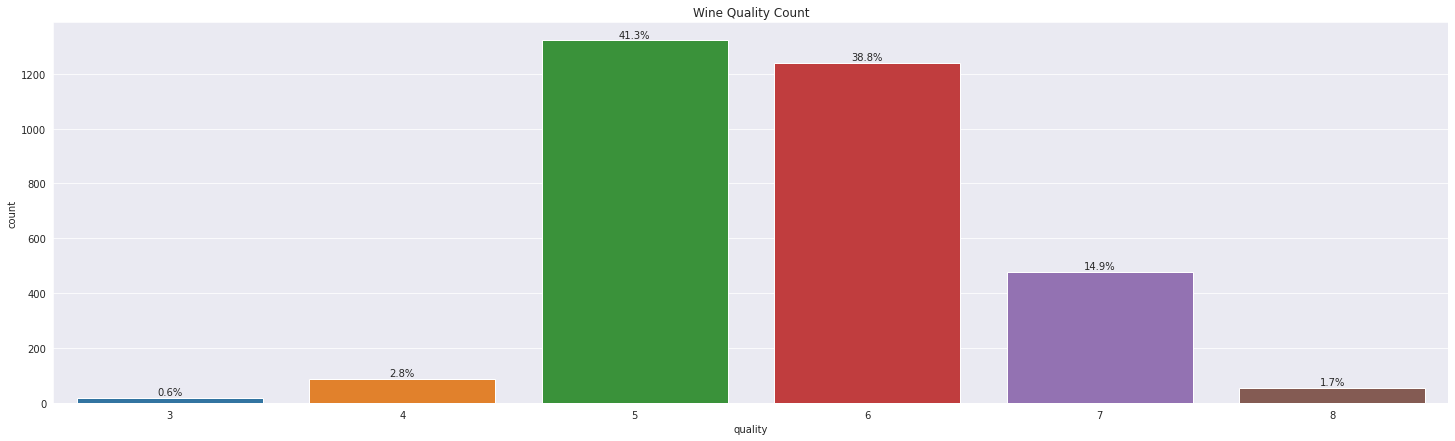

In [13]:
fig, ax = plt.subplots(figsize = (25,7))
sns.countplot(x= df_train[target])
plt.title("Wine Quality Count")

total = len(df_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

In [14]:
df_train[target].unique()

array([6, 7, 5, 4, 8, 3])

<span style="color:blue;font-size:1.5em;">Notes Imbalanced dataset: </span>
* We have certain wine qualities that are more prolific than others
* We need to investigate our metric to understand how it is affected by imbalanced data 

<span style="color:red;font-size:1.3em;">Potential Solutions: Imbalanced Data  </span>
1. **Stratified Cross-validation** : we will try keep the same number of each target class in each fold. This should help the model understand the imbalance
2. **Class Weighting** : Certain models allow for class weightings to be added as parameters
3. **Additional Features** : Create features that help our model identify distingishing characteristics of certain classes
4. **Over /Under Sampling**: 
 * [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) creates sythetic data by Oversampling minority classes
     * Testing required as sythetic data could likely negatively impact score
 * Undersampling: We can remove majority samples to even out the classes
     * Due to the small number of samples, removing samples would be a poor choice as this reduces our dataset significantly

# 🚀 Distribution & Skewness 🚀
Why look at distribution:
* Many ML algorithms are more accurate when training on data that is normally distributed. Specifically linear models like LDA, Gaussian Naive Bayes, Logistic Regression, Linear Regression as they are explicitly calculated from the assumption that the residuals are Normally (Guassian) distributed 
* Note that Gradient boosting models can compute faster with normally distrubuted values but dont neccessarily improve with normally distributed data 

##### **Normal Distribution (centre around the mean)**

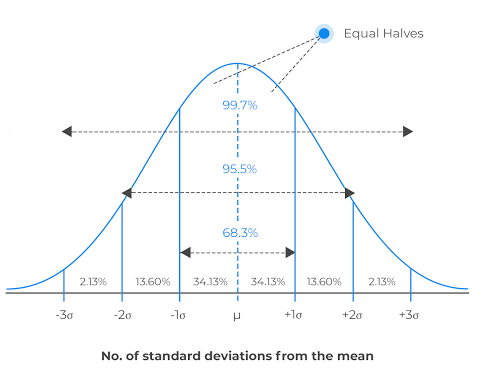

In [15]:
numerical = [col for col in df_train.select_dtypes(["int64", "float64","int32", "float32"]).columns if col not in [target]]
categorical = [col for col in df_train.select_dtypes("object").columns if col!=target]
print("Numerical Columns:\n",numerical)
print("\n")
print("Categorical Columns:\n",categorical)

Numerical Columns:
 ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


Categorical Columns:
 []


#### Categorical Data (Count)
Categorical data does not need to be normally distrubuted as it is discrete, we will therefore visualise the data with countplots/barplots to get a better indication of how it looks against the target

Note: we dont have any categorical columns for this data, so the below is ignored 

In [16]:
if len(categorical)>0:
    fig,ax = plt.subplots(4,2,figsize = (25,25))
    total = len(df_train)
    ax = np.ravel(ax)

    for i,col in enumerate(categorical):
        sns.countplot(ax = ax[i],x = df_train[col], hue=df_train[target])
        sns.countplot(ax = ax[i],x = df_train[col], hue=df_train[target])
        ax[i].tick_params(labelrotation=90)
        ax[i].set_title(f"{col}",fontsize = 12)
        ax[i].legend(title='Attrition', loc='upper right', labels=['No Attrition', 'Attrition'])
        ax[i].set(xlabel=None)

        for p in ax[i].patches:
            percentage = f'{100 * p.get_height() / total:.1f}%\n'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax[i].annotate(percentage, (x, y), ha='center', va='center')

    fig.suptitle("Employee Attrition by categorical columns",fontsize = 20)
    plt.tight_layout()
    plt.show()

## Skewness & Kurtosis
* Skewness is a measure of the lack of symmetry of the data ( how "off" the  data is from normal distrubution i.e its skewness)
    * Skewness > 1 = highly positively skewed
    * Skewness < -1 =  highly negatively skewed
    * Skewness close to 0 = Normally distributed 
* Kurtosis is a measure of whether the data is heavy-tailed or light-tailed relative to a normal distribution

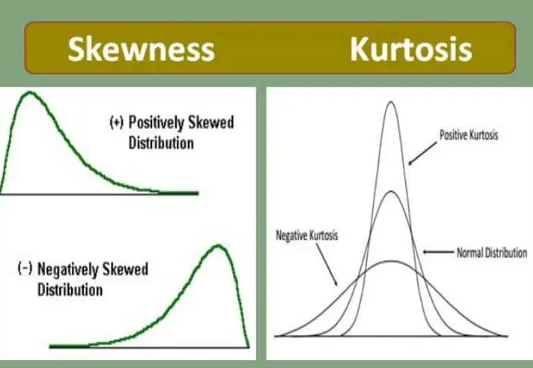

#### **NB**: Hair et al. (2010) and Bryne (2010) argued that data is considered to be normal if skewness is between ‐2 to +2 and kurtosis is between ‐7 to +7

In [17]:
# We concatenate test data to train to get a full view of the data as we know it
skew_df = pd.concat((df_train.drop(target,axis =1), df_test), axis =0).skew(numeric_only=True).sort_values()
print("Skewly distributed columns by skewness value:\n") 
display(skew_df)

Skewly distributed columns by skewness value:



density                 0.147377
pH                      0.232995
citric acid             0.271634
volatile acidity        0.697208
alcohol                 0.789138
free sulfur dioxide     0.826404
fixed acidity           0.991695
total sulfur dioxide    1.308484
sulphates               2.086318
residual sugar          4.288313
chlorides               7.016995
dtype: float64

In [18]:
kurtosis_df = pd.concat((df_train.drop(target,axis =1), df_test), axis =0).kurtosis().sort_values()
print("Tailed columns by kurtosis value\n") 
display(kurtosis_df)

Tailed columns by kurtosis value



citric acid             -0.821532
alcohol                 -0.097520
pH                       0.542226
free sulfur dioxide      0.686953
density                  0.765202
fixed acidity            0.930621
volatile acidity         1.160855
total sulfur dioxide     2.678366
sulphates               10.576394
residual sugar          30.692751
chlorides               76.649309
dtype: float64

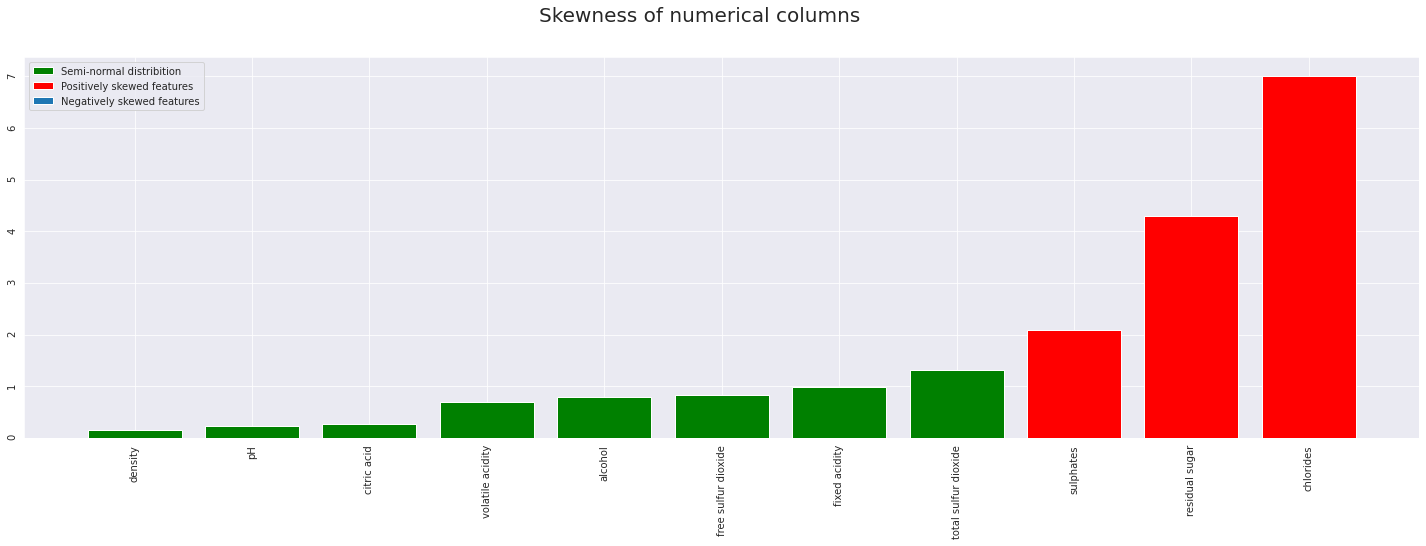

In [19]:
fig,ax = plt.subplots(figsize=(25,7))

ax.bar(x = skew_df[(skew_df<2)& (skew_df>-2)].index, height = skew_df[(skew_df<2)& (skew_df>-2)], color = "g", label= "Semi-normal distribition")
ax.bar(x = skew_df[skew_df>2].index, height = skew_df[skew_df>2], color = "r", label = "Positively skewed features")
ax.bar(x = skew_df[skew_df<-2].index, height = skew_df[skew_df<-2], color = "b", label = "Negatively skewed features")
ax.legend()
fig.suptitle("Skewness of numerical columns",fontsize = 20)
ax.tick_params(labelrotation=90)

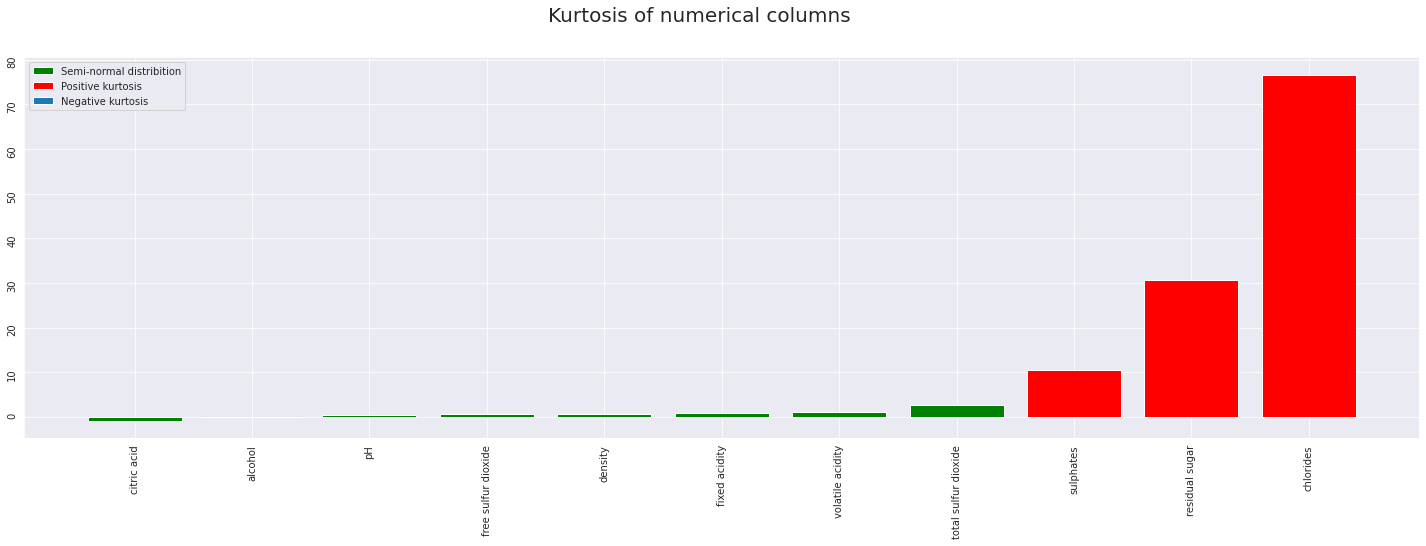

In [20]:
fig,ax = plt.subplots(figsize=(25,7))

ax.bar(x = kurtosis_df[(kurtosis_df<7)& (kurtosis_df>-7)].index, height = kurtosis_df[(kurtosis_df<7)& (kurtosis_df>-7)], color = "g", label= "Semi-normal distribition")
ax.bar(x = kurtosis_df[kurtosis_df>7].index, height = kurtosis_df[kurtosis_df>7], color = "r", label = "Positive kurtosis")
ax.bar(x = kurtosis_df[kurtosis_df<-7].index, height = kurtosis_df[kurtosis_df<-7], color = "b",  label = "Negative kurtosis")
ax.legend()
fig.suptitle("Kurtosis of numerical columns",fontsize = 20)
ax.tick_params(labelrotation=90)

<span style="color:blue;font-size:1.5em;">Notes on Distribution (Skewness and Kurtosis) </span>
* The degree of distibution of data further for a normal distribution will affect certain model performance (specifically linear models) 
* As such we need to try correct this feattures that have positive / negative kurtosis and skewness

<span style="color:red;font-size:1.3em;">Potential Solution: Distribution (Guassian) Transformation </span>
* Investigate Transformations to create normally distributed features (Log transform, Cube features, boxcox , Scaling etc)
 * Specifically the columns: 'sulphates', 'residual sugar', 'chlorides' as these show high kurtosis and skewnes

# 👨🏼‍🌾 Distribution Transformations: 👨🏼‍🌾
* Log transform 
* Scaling (Quantile) 
* BoxCox 
* Cube root / Square root

In [21]:
non_dist_cols = ['sulphates', 'residual sugar', 'chlorides']

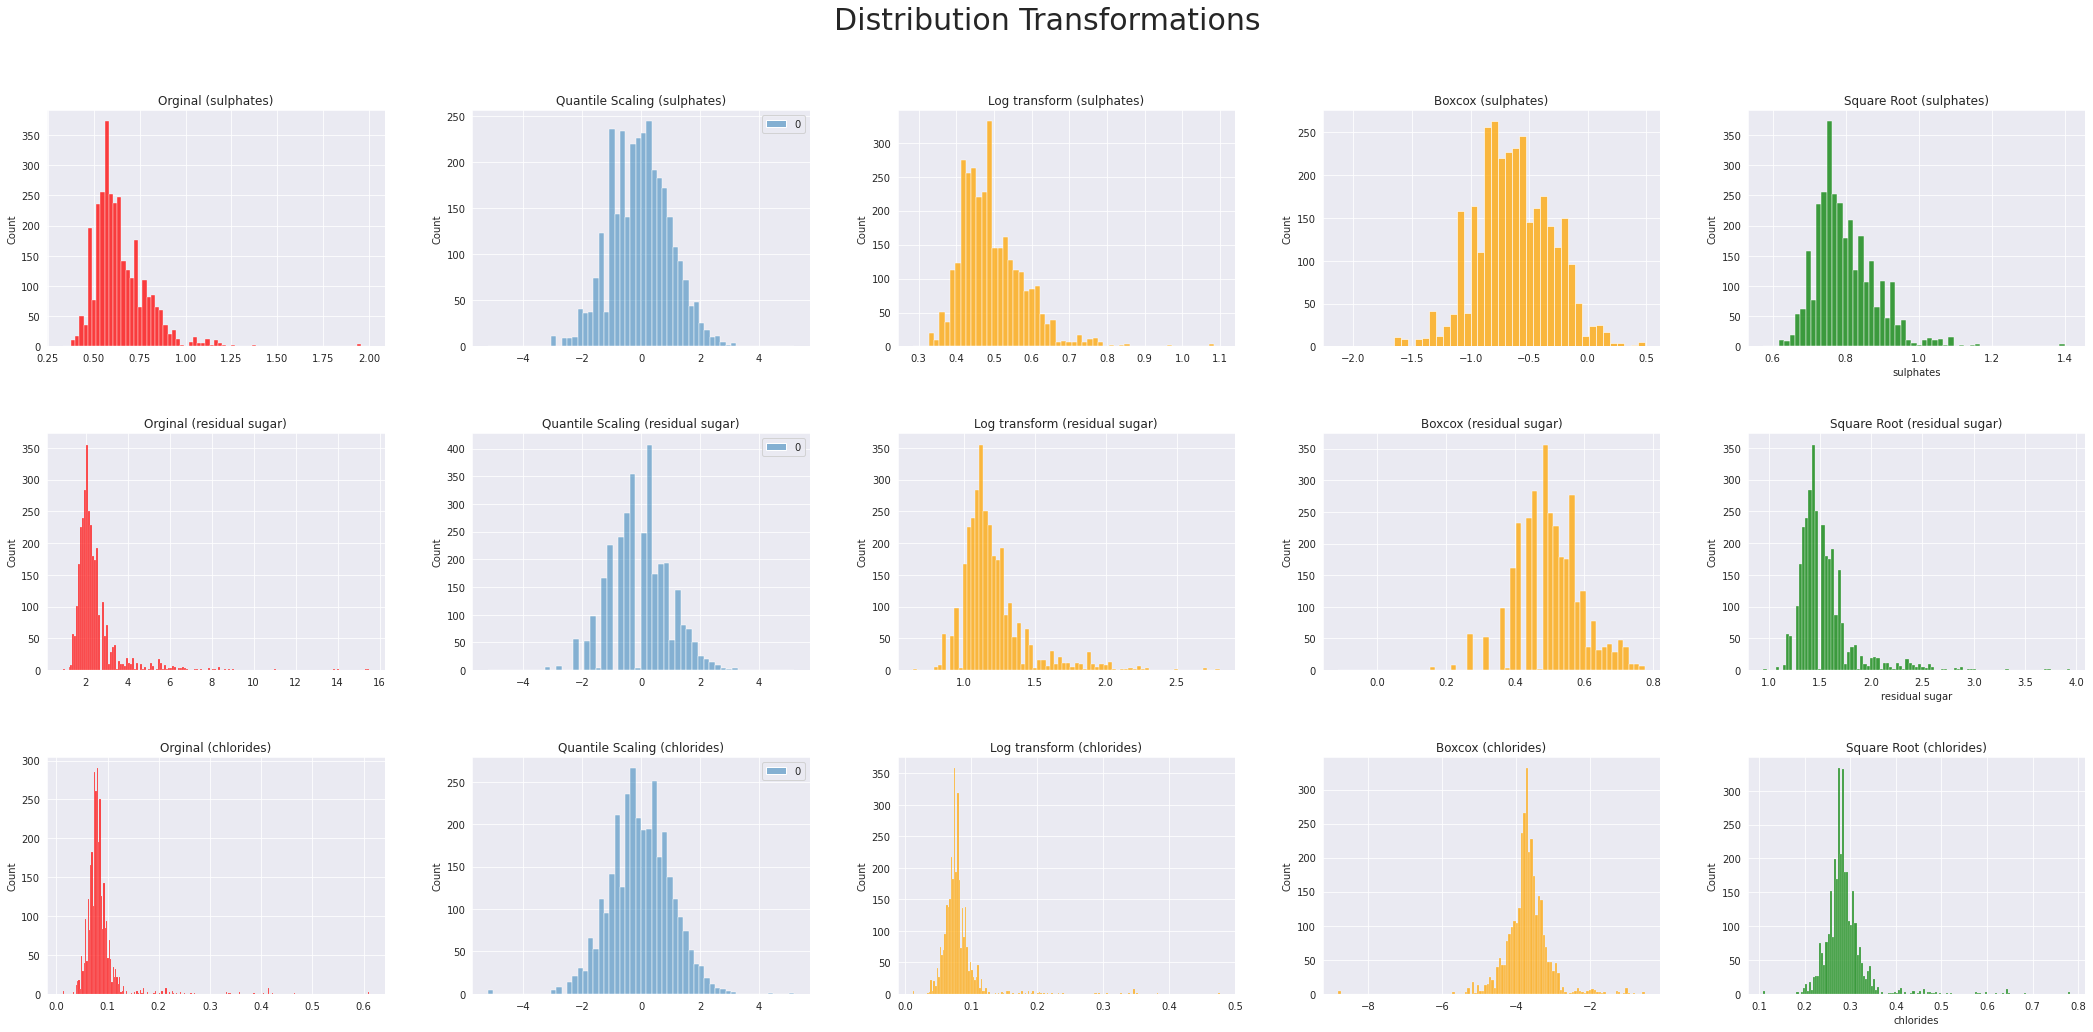

In [22]:
fig,ax = plt.subplots(len(non_dist_cols),5, figsize = (30,15))
for i,col in enumerate(non_dist_cols):
    #scale
    scaler = QuantileTransformer(output_distribution="normal")
    quant_df = scaler.fit_transform(df_train[[col]])

    sns.histplot(x= df_train[col],ax= ax[i,0], color = "r")
    sns.histplot(quant_df,ax= ax[i,1] )
    sns.histplot(np.log1p(df_train[col]), ax = ax[i,2], color= "orange")
    try:
        sns.histplot(boxcox(df_train[col])[0], ax = ax[i,3], color= "orange")
    except:
        pass
    sns.histplot(np.sqrt(df_train[col]), ax = ax[i,4], color= "green")
    ax[i,0].set_title(f"Orginal ({col})")
    ax[i,0].set(xlabel=None)
    ax[i,1].set_title(f"Quantile Scaling ({col})")
    ax[i,2].set_title(f"Log transform ({col})")
    ax[i,2].set(xlabel=None)
    ax[i,3].set_title(f"Boxcox ({col})")
    ax[i,4].set_title(f"Square Root ({col})")
plt.suptitle("Distribution Transformations",fontsize = 30)
plt.tight_layout(pad = 4)
plt.show()

<span style="color:blue;font-size:1.5em;">Notes on Distribution: </span>
* We are looking for the best process to create a normally distributed graphs
* From the above we see that **QuantileScaling** is the best process for most of the features as this gives us a nice bell shaped curve. 

**Note** that Quantile Scaling will always be a good scaling process for these distributions as we assume they are non-parametric 

# 🧩 Correlation & Mututal Information  🧩
* Features that contain similar (correlated / mutual) information negatively impact certain models as this can cause **overfitting**.

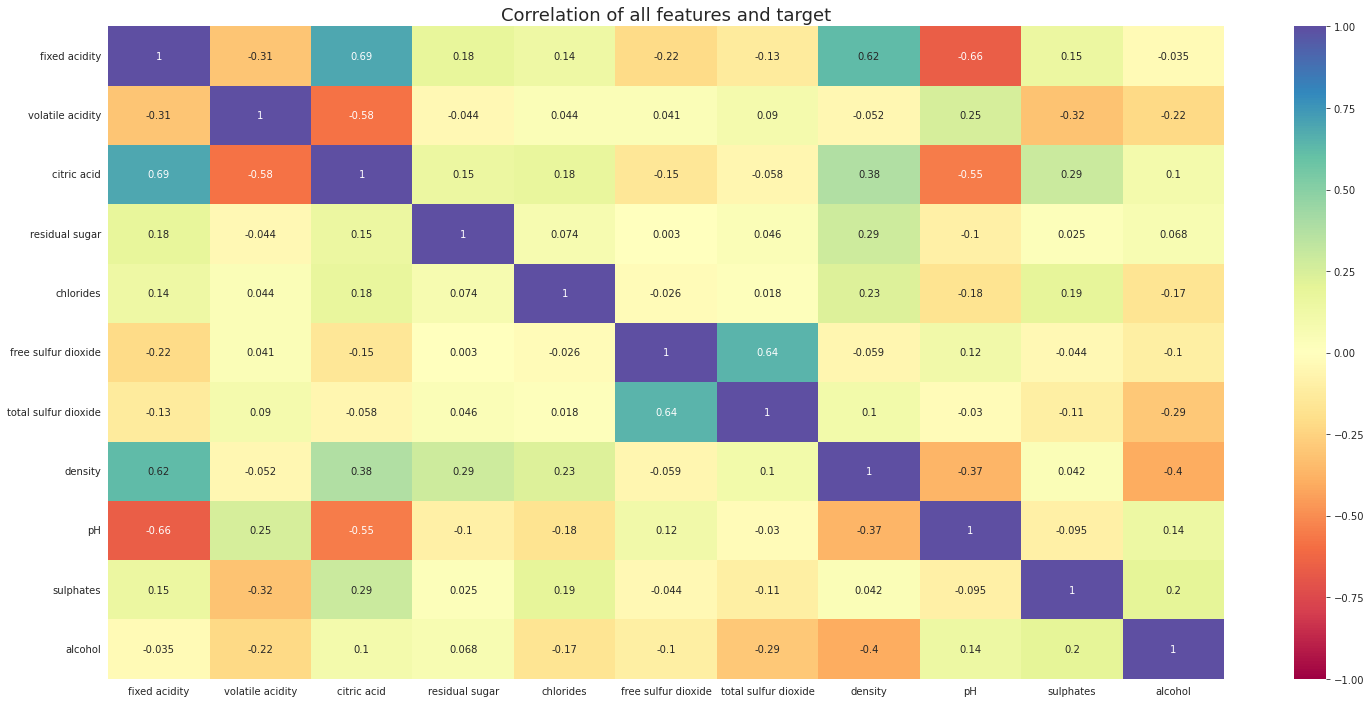

In [23]:
plt.figure(figsize = (25,12))
sns.heatmap(pd.concat((df_train.drop(target,axis =1), df_test), axis =0).corr(),vmin = -1, vmax = 1, cmap = "Spectral", annot = True)
plt.title("Correlation of all features and target", fontsize= 18)
plt.show()

<span style="color:blue;font-size:1.5em;">Notes on Correlation: </span>
* Features that contain similar (correlated / mutual) information negatively impact certain models as this can cause overfitting.
* High correlation between a number of features  for example: 
 * 'ph' and 'fixed acidity' have a large negative correlation 
 * 'density' and 'fixed acidity' have a large positive correlation


<span style="color:red;font-size:1.5em;">Potential Solutions: Correlation reduction</span>
 #### 1. Reduce Overfitting
 * Linear models will be impacted negatively by correlated features, due to overfitting ==> use Lasso / Ridge models as these model regularize our feature inputs
 * Gradient boosting models will tend to overfit with highly correlated features ==> [apply overfitting techniques ](https://medium.com/geekculture/how-to-stop-overfitting-your-ml-and-deep-learning-models-bb8324ace80b) through hyperparameter tuning

#### 2. Dimensionality Reduction 
 * Trial and error: **Remove columns** and run the model i.e. Drop highly correlated columns and rerun model 
 * **Decomposition**  i.e. use Principal Component Analysis (PCA) on highly correlated features which removes correlation 
 
 
#### lets apply PCA and regularize our models with hyperparameter tuning and using specific model types

### 🎇 Pre-Training Feature Selection:  Mutual Information  🎇
There are a number of processes and algorithms that can help us select features before we train our model. We will try Mutual Information. However a few others include:
* [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) 
* [Model importance ](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)
* [Sequential Feature Selection ](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector)

### Mutual Information
* Mutual information (MI) measures the dependecy of features to the target. 
* Positive values are show a dependecy between the feature and the target i.e. the feature is important to the target and its predictions 
* Values equal to zero shows independency to the target and are less important to target predictions 

**Note**: We want features that have a large mutual information with our Target (i.e. positive values) and remove features with little to no mutual information. This **should** improve our model performance.

We will implement a mutual information test using Sklearn's [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html). This will apply our mutual information algorithm (to test for dependency) and select K highest features (Note: we will set k to be equal to all the features to visualise every column) 

In [24]:
 # feature selection
def select_features(df):
    df_trn = pd.get_dummies(df_train,drop_first =True) #onehotencoding needed for categorical columns 
    X_train, X_test, y_train, y_test = train_test_split(df_trn.drop(target,axis =1), df_trn[target], test_size=0.33, random_state=1) 
    
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    columns = X_train.columns
    return X_train_fs, X_test_fs, fs, columns 

# feature selection
X_train_fs, X_test_fs, fs, columns = select_features(df_train)

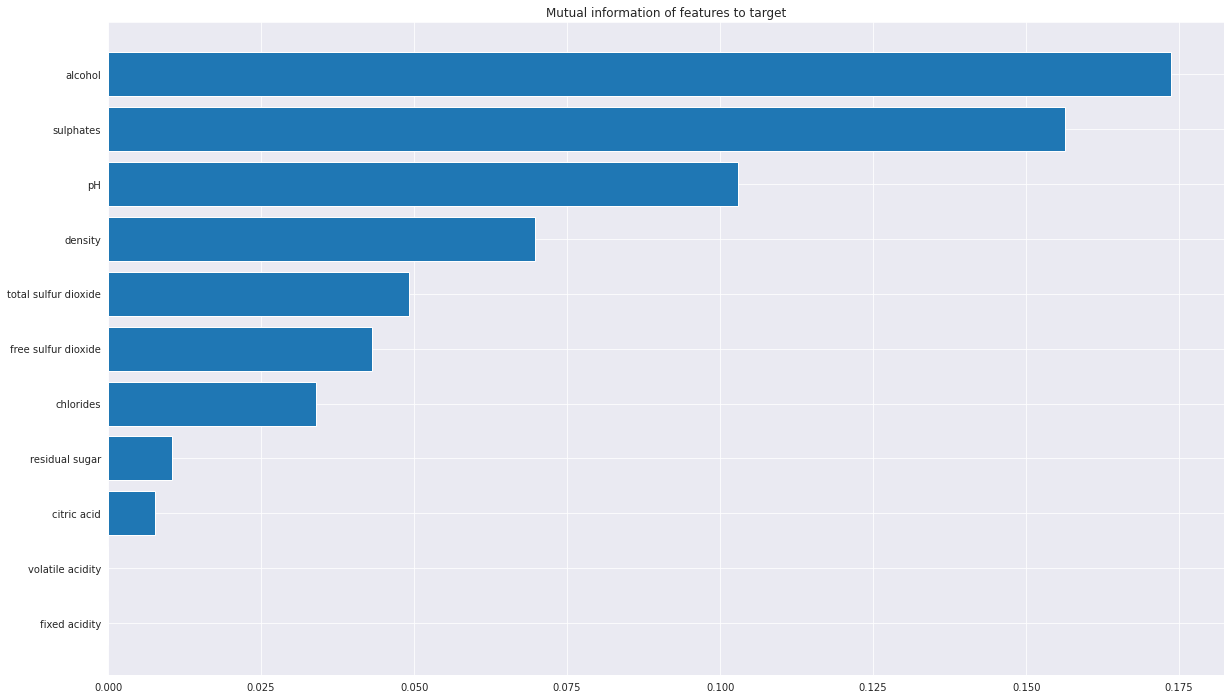

In [25]:
selected_feats = pd.DataFrame(fs.scores_, index = columns).sort_values(by = 0 , ascending = True)

fig,ax = plt.subplots(figsize =(20,12))
plt.barh(y =columns, width= selected_feats[0])
plt.title("Mutual information of features to target")
plt.show()

<span style="color:blue;font-size:1.5em;">Notes on Mutual information </span>
* We can conclude that certain features are highly dependent on our Target(i.e. Alcohol). We should potentially look to apply feature engineering to these features, so as to further improve our model accuracy.  
* There is little to no mutual information for 'fixed acidity' and 'volatile acidity' and could be potential for removal. However we will note these features and train our model to confirm feature importance below 

# 🦠 Outliers / Distribution 🦠
* Outliers will skew certain models and result in poor local optimums in trained models and reduce model performance. As such we need to assist our models in identifying outliers:
* We will identify features with a large number of outliers through:
    * Boxplots visualization
    * zscore analysis (we calculate each samples standard deviation from the feature mean)

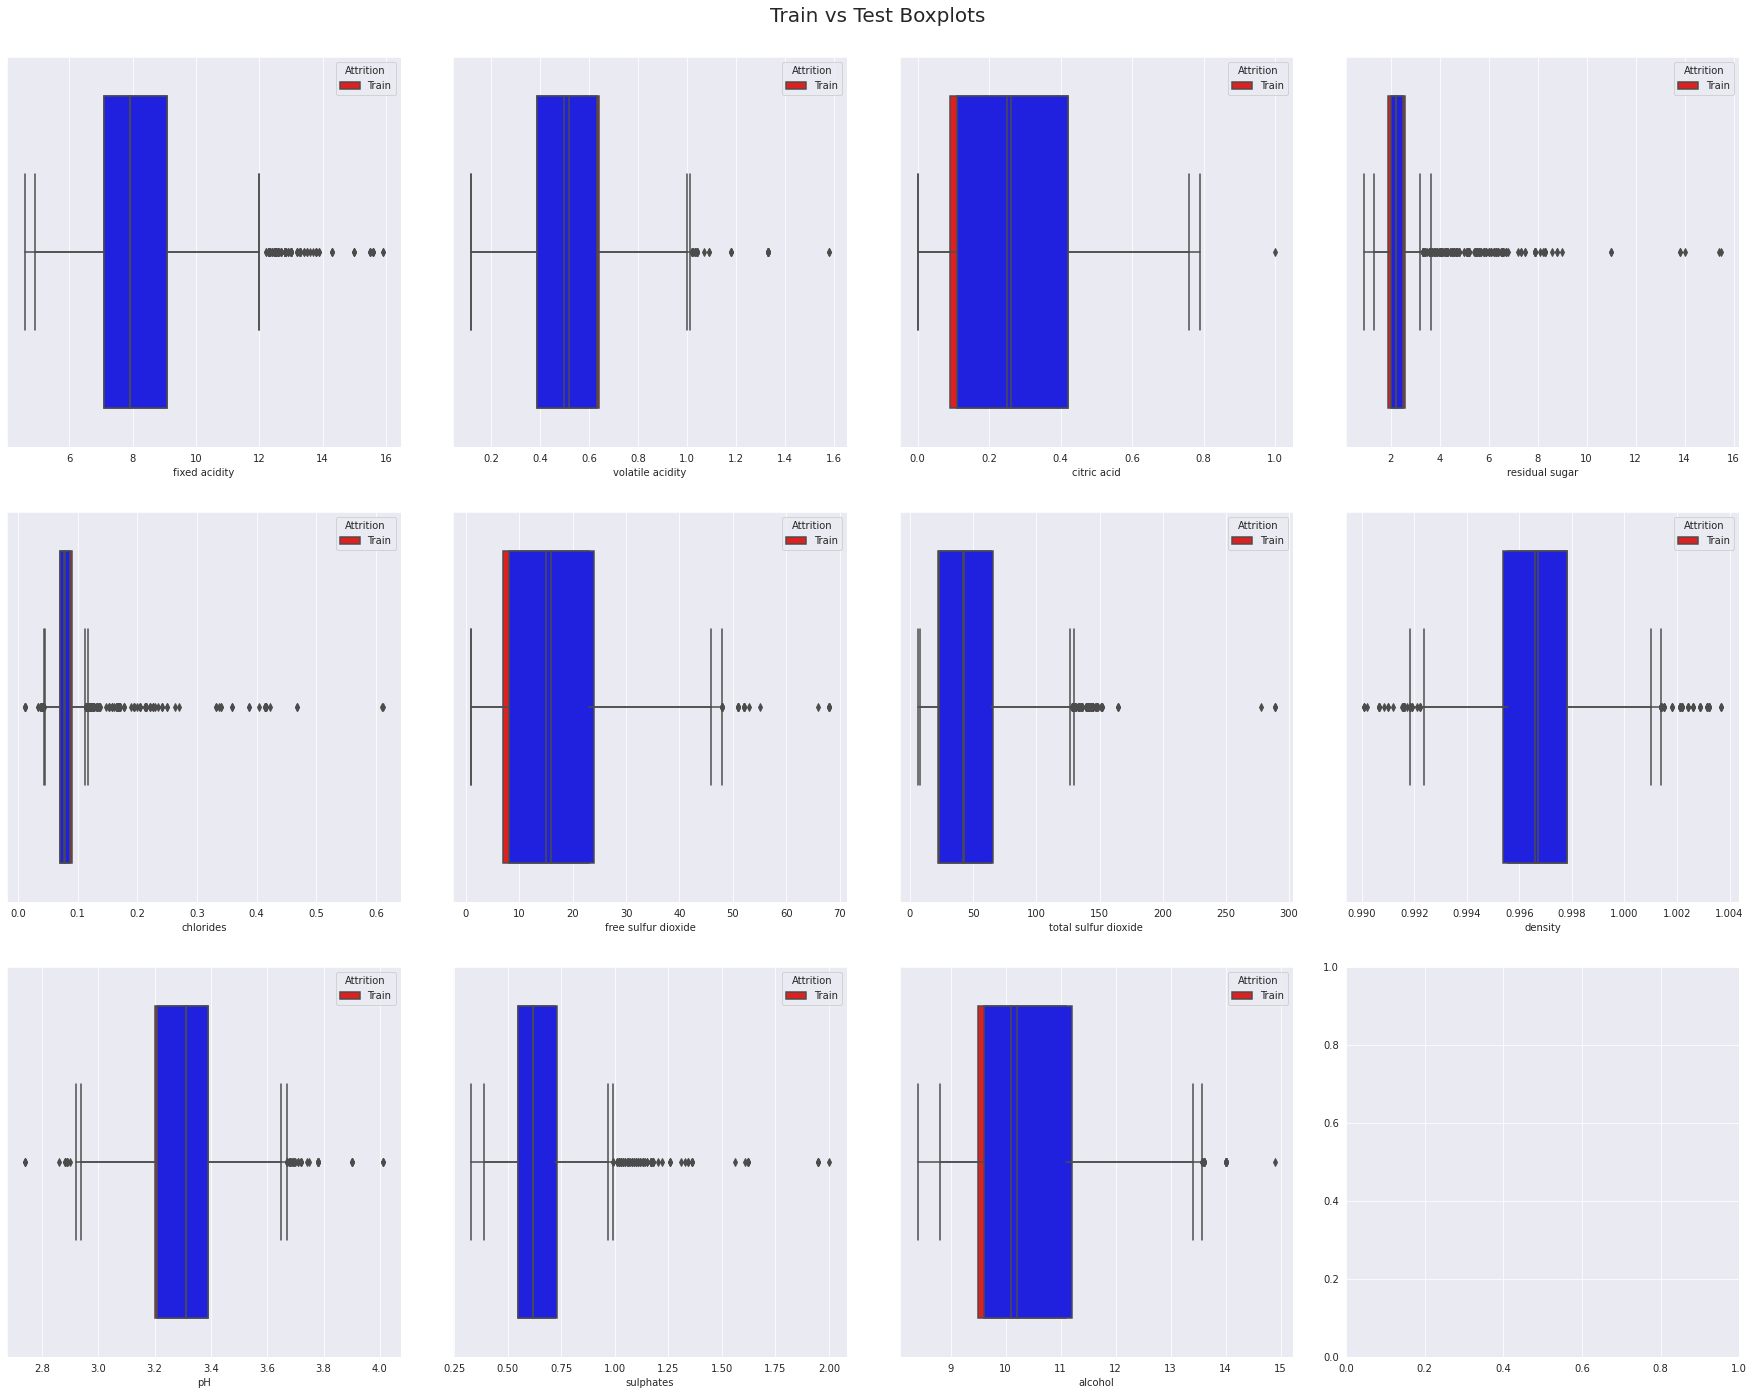

In [26]:
fig,ax = plt.subplots(int(np.ceil(len(numerical)/4)),4,figsize = (25,20))
ax = np.ravel(ax)

for i,col in enumerate(numerical):
    sns.boxplot(ax = ax[i], x = df_train[col], color= "red")
    sns.boxplot(ax = ax[i], x = df_test[col], color= "blue")

    ax[i].legend(title='Attrition', loc='upper right', labels=['Train'])
    
fig.suptitle("Train vs Test Boxplots",fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

In [27]:
from scipy.stats import zscore
df_zscores = pd.concat((df_train.drop(target,axis =1), df_test), axis =0)[numerical].apply(zscore)
print("Sample z-scores by feature:\n")
df_zscores.head()

Sample z-scores by feature:



fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.207198         -0.156614     0.645856       -0.231771  -0.310616   
1       0.555885         -1.293643     2.439005       -0.134110   0.281888   
2      -0.735486         -0.099763    -1.252772       -0.329432  -0.747198   
3      -0.148500          1.946889    -0.250718        0.158873   0.032412   
4       0.086295         -0.952535     0.171199       -0.134110  -0.123510   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             1.321707             -0.284651 -0.540464  0.129168   0.841402   
1             1.321707              0.566701  0.983593  0.060545   0.156235   
2            -1.357988             -1.105597 -0.064872  1.432988   0.567335   
3            -0.564005              0.505890  0.313440 -0.762920  -0.802999   
4            -0.663253             -0.102218 -1.232235 -0.762920   4.883889   

    alcohol  
0  1.594033  
1  2.265892  
2  0.826195  
3 -0.613503  
4 -0.901443

Lets visualise this better with boxplots of z-scores

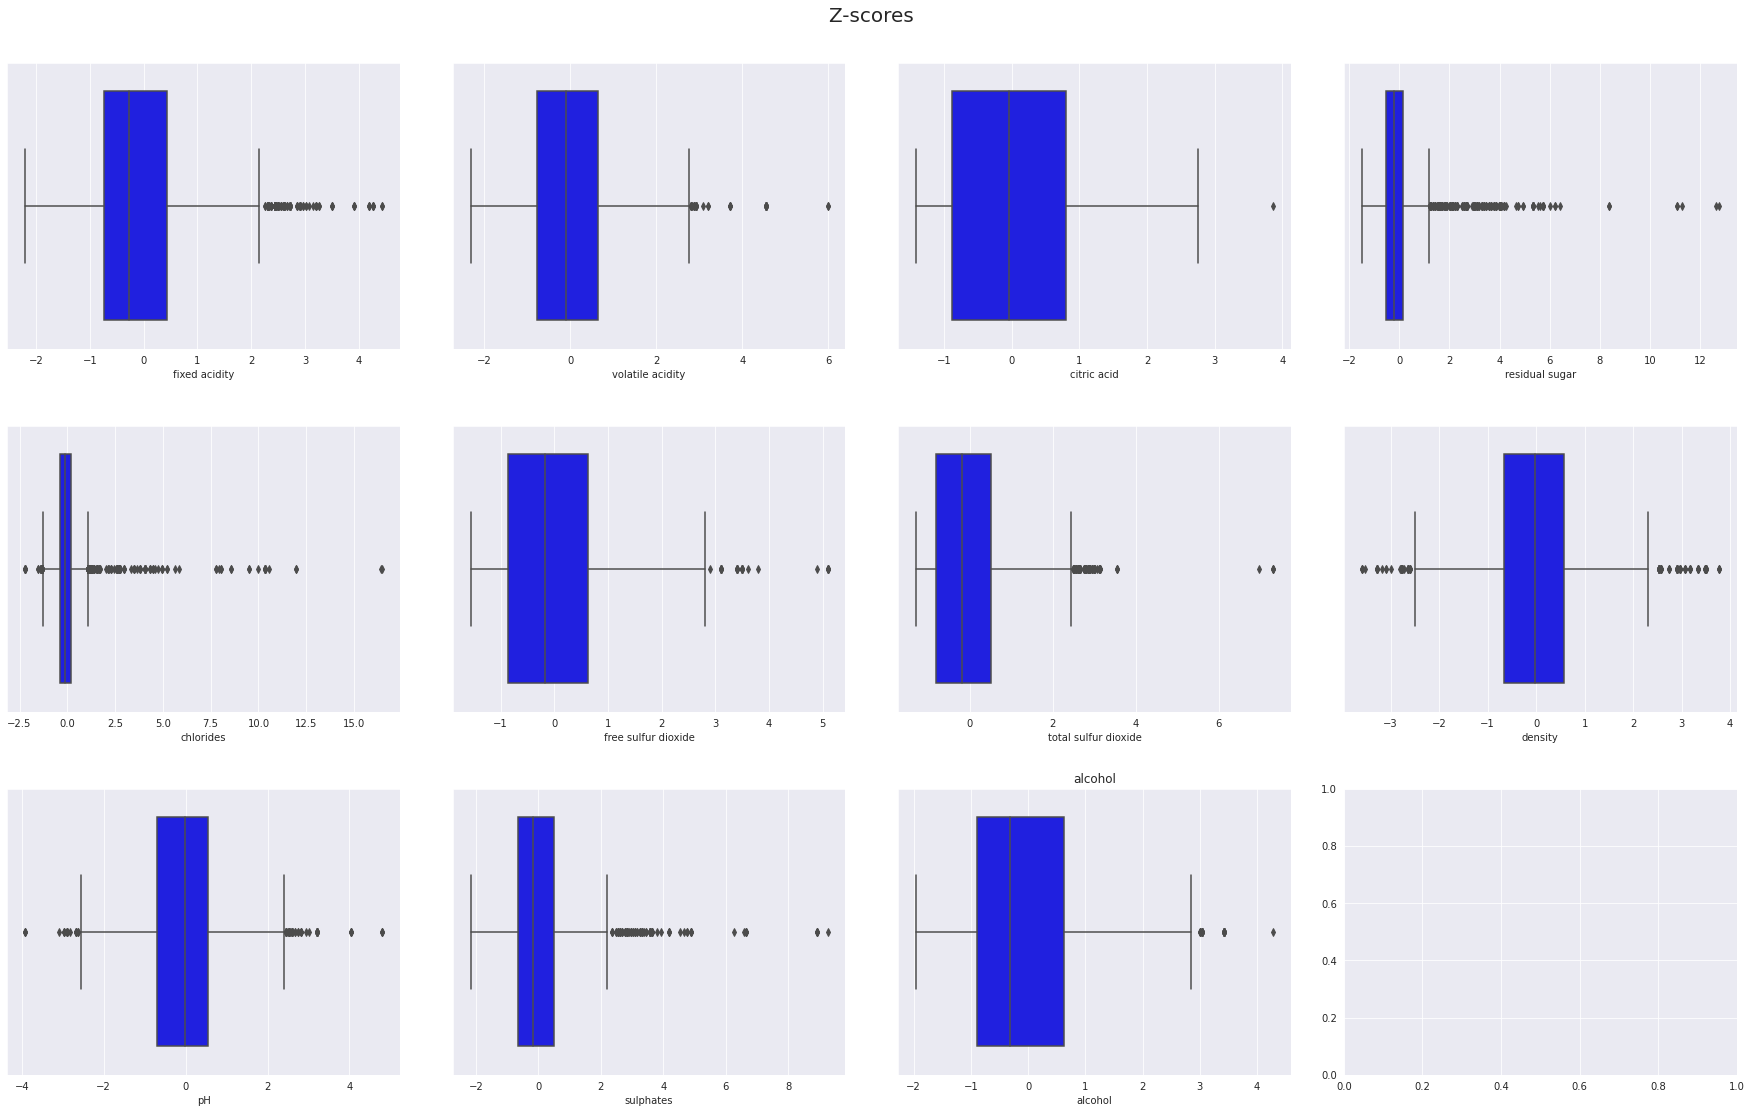

In [28]:
fig,ax = plt.subplots(int(np.ceil(len(numerical)/4)),4,figsize = (25,16))
ax = np.ravel(ax)

for i,col in enumerate(df_zscores.columns):
    sns.boxplot(ax = ax[i], x = df_zscores[col], color= "blue")
ax[i].set_title(f"{col}")
fig.suptitle("Z-scores ",fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

<span style="color:blue;font-size:1.5em;">Notes: Columns with outliers </span>
* Columns with a large number of outliers will skew our models. 
* From eye balling the above graphs we have a number of columns with outliers
 * fixed acidity
 * residual sugar
 * chlorides
 * Density
 * ph 
 * sulphates

<span style="color:red;font-size:1.3em;">Potential Solutions for Outliers</span>
* Assist model in identifying outliers:
 * **RobustScaler (scaling data):** This is a simple and effective method
 * **Add column Z-score:** we wont do this as this will add another column of data that may negatively affect our model
* **Outlier removal:** as stated above we dont want to reduce our sample size any further
 * [Notebook on outlier removal ](https://www.kaggle.com/code/nareshbhat/outlier-the-silent-killer)

In [29]:
outliers = ['fixed acidity', 'residual sugar', 'chlorides','pH' ,'sulphates']

# 🦠Metric Understanding ([Quadratic Weighted Kappa](https://www.kaggle.com/competitions/playground-series-s3e5/overview/evaluation)) 🦠
Quadratic weighted kappa also called [Cohen's Kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa) with Quadratic weightings, measures the degree of agreement between two raters i.e. the agreement between an models predictions and the target actuals, where the higher the agreement the higher the weight.

* The metric outputs values from -1 and 1, with 0 noting random agreement and 1 noting complete agreement
 *  It is possible for the statistic to be negative. which can occur by chance if there is no relationship between the predictions and target
* The formula is a complicated one such that we can rather use [sklearn's library](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html), with weights =  ‘quadratic’

<span style="color:blue;font-size:1.2em;">Notes </span>
* as per the [competition](https://www.kaggle.com/competitions/playground-series-s3e5/overview/evaluation), parts of the formular for this metric is calculated assuming that there is **no correlation between values**.

<span style="color:red;font-size:1.3em;">Potential Solutions: Remove correlation</span>
* We can use feature decomposition with Principal Component Analysis (PCA) to reduce correlation

# 🎯 Feature Engineering 🎯
* Feature engineering is the most complex part of data science as this requires certain domain knowledge as well as trial and error. 
* This is usually an iterative process by adding/ removing features and training and analysing models 
* We will leave leave this section bare for now 

In [30]:
df_trn = df_train.copy(deep = True)
df_tst = df_test.copy(deep = True)

## 🧬 Encoding 🧬

<span style="color:orange;font-size:1.5em;">Solution Implementation: Encoding </span>
* Onehotencoding vs WOEencoder vs LabelEncoder

As our feautures are all numerical we can ignore encoding for this project

In [31]:
if len(categorical)> 0:
    df_trn = pd.get_dummies(df_train,drop_first =True)
    df_tst = pd.get_dummies(df_test,drop_first =True)
df_trn.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            8.0              0.50         0.39             2.2      0.073   
1            9.3              0.30         0.73             2.3      0.092   
2            7.1              0.51         0.03             2.1      0.059   
3            8.1              0.87         0.22             2.6      0.084   
4            8.5              0.36         0.30             2.3      0.079   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 30.0                  39.0  0.99572  3.33       0.77   
1                 30.0                  67.0  0.99854  3.32       0.67   
2                  3.0                  12.0  0.99660  3.52       0.73   
3                 11.0                  65.0  0.99730  3.20       0.53   
4                 10.0                  45.0  0.99444  3.20       1.36   

   alcohol  quality  
0     12.1        6  
1     12.8        6  
2     11.3        7  
3      9.8        5  
4      9.5        6

#### Fix target class: Wine Quality 
The target has 6 classes however they start at 3. We need to change this to start at 0 as certain models will do this automatically or will fail as it expects the target to start from 0
* We need to remember to revert the change when submitting our predictions

In [32]:
#map the classes to start from 0
df_trn[target] = df_trn[target].map({3:0,
                    4:1,
                    5:2,
                    6:3,
                    7:4,
                    8:5})

## 🕵🏻Correlation reduction w/ PCA 🕵🏻
PCA is a simple methodology to remove correlation from our dataset and as such should inhibit our models from overfitting

In [33]:
from sklearn.decomposition import PCA

In [34]:
# we will only look at certain features that are highly correlated and run pca  as incorrectly running PCA on the wrong columns could decompose important features. This is therefore a trial and error exercise 

pca_cols = ["pH","fixed acidity"]
pca_ = PCA(n_components=1 ,whiten= False)
df_trn["pca_1"] = pca_.fit_transform(df_trn[pca_cols])
df_tst["pca_1"] = pca_.fit_transform(df_tst[pca_cols])

for cols in pca_cols:
    for df in [df_trn,df_tst]:
        df.drop(cols, axis =1, inplace = True)

df_trn

volatile acidity  citric acid  residual sugar  chlorides  \
0                0.500         0.39             2.2      0.073   
1                0.300         0.73             2.3      0.092   
2                0.510         0.03             2.1      0.059   
3                0.870         0.22             2.6      0.084   
4                0.360         0.30             2.3      0.079   
...                ...          ...             ...        ...   
3194             0.510         0.13             2.3      0.076   
3195             0.620         0.08             1.9      0.068   
3196             0.600         0.08             2.0      0.090   
3197             0.550         0.10             2.2      0.062   
3198             0.645         0.12             2.0      0.075   

      free sulfur dioxide  total sulfur dioxide  density  sulphates  alcohol  \
0                    30.0                  39.0  0.99572       0.77     12.1   
1                    30.0                  67.0  0.99854       0.67     12.8   
2                     3.0                  12.0  0.99660       0.73     11.3   
3                    11.0                  65.0  0.99730       0.53      9.8   
4                    10.0                  45.0  0.99444       1.36      9.5   
...                   ...                   ...      ...        ...      ...   
3194                 29.0                  40.0  0.99574       0.75     11.0   
3195                 28.0                  38.0  0.99651       0.82      9.5   
3196                 32.0                  44.0  0.99490       0.58     10.5   
3197                 39.0                  51.0  0.99512       0.76     11.2   
3198                 32.0                  44.0  0.99547       0.71     10.2   

      quality     pca_1  
0           3 -0.346393  
1           3  0.951981  
2           4 -1.255934  
3           2 -0.238989  
4           3  0.160331  
...       ...       ...  
3194        3 -2.048749  
3195        3 -1.549599  
3196        2 -2.150327  
3197        3 -2.453896  
3198        2 -2.456809  

[3199 rows x 11 columns]

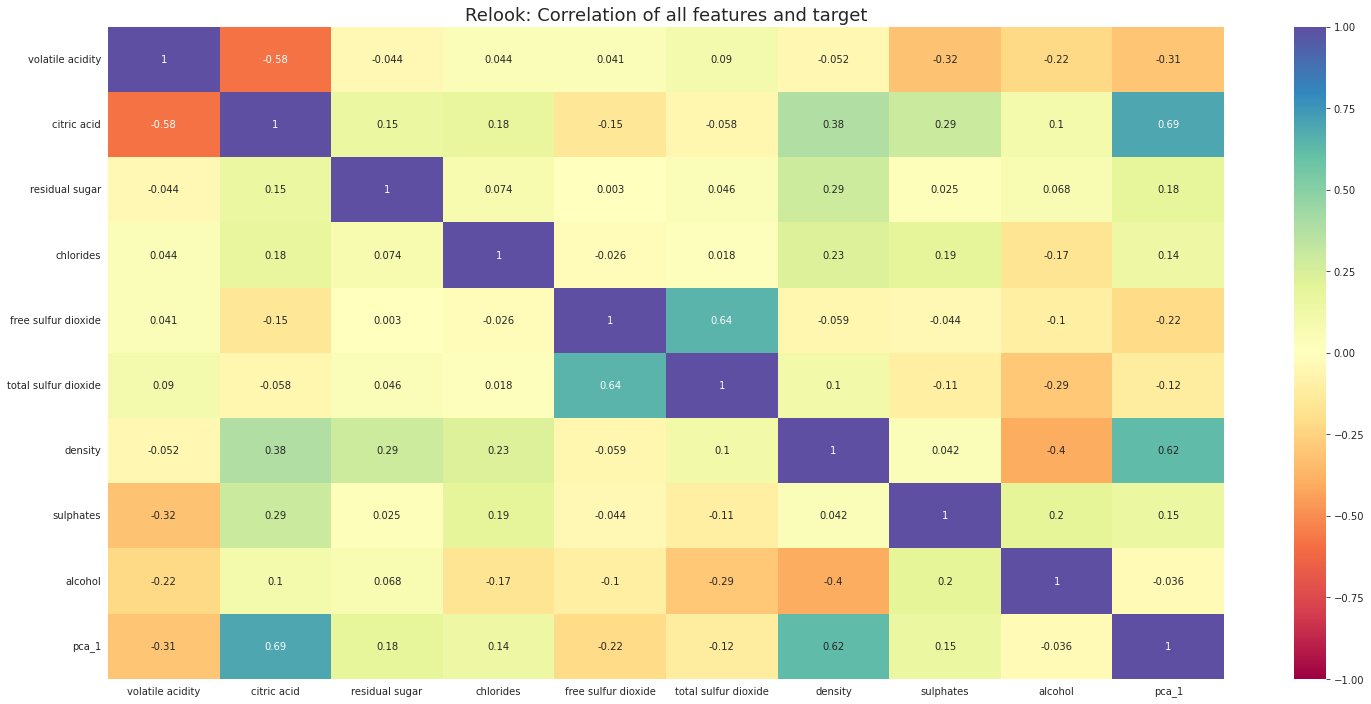

In [35]:
plt.figure(figsize = (25,12))
sns.heatmap(pd.concat((df_trn.drop(target,axis =1), df_tst), axis =0).corr(),vmin = -1, vmax = 1, cmap = "Spectral", annot = True)
plt.title("Relook: Correlation of all features and target", fontsize= 18)
plt.show()

## Split

In [36]:
X = df_trn.drop([target],axis =1)
y = df_trn[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# 🧊 Basic Modelling 🧊
We run a basic model for testing in order to:
* Quickly confirm any changes made to our code 
* Quickly check if additional features/processes cause large changes in our models score 
* Evaluate feature importance

#### Below we create a custom metric function for models 

In [37]:
# create a custom metric for lightgbm
def kappa_score(dy_true, dy_pred):
    pred_labels = dy_pred.reshape(len(np.unique(dy_true)),-1).argmax(axis=0)
    
    ks = cohen_kappa_score(dy_true, pred_labels, weights ='quadratic' )
    is_higher_better = True

    return "kappa_score", ks, is_higher_better

In [38]:
# Note: scale_pos_weight is total majoriity / total minority class ==1477/200
# class_pos_weight =   (len(df_trn) - sum(df_trn[target]))/sum(df_trn[target])
# print("scale_pos_weight:",class_pos_weight)

print("skew columns:\n", non_dist_cols)
outliers = [col for col in outliers if col not in non_dist_cols + pca_cols]
print("outliers:\n", outliers)
scaled_cols = [col for col in df_trn.drop(target,axis =1).columns if col not in outliers + non_dist_cols+pca_cols]
print("scaled_cols:\n", scaled_cols) 

if len(scaled_cols)==0:
    SCALING = False

skew columns:
 ['sulphates', 'residual sugar', 'chlorides']
outliers:
 []
scaled_cols:
 ['volatile acidity', 'citric acid', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'alcohol', 'pca_1']


<span style="color:orange;font-size:1.5em;">Solution Implementation: Skewness,  Outliers , Scaling & Imbalanced data </span>
* **Quantile Scaling** for non-stributed features should normalise our data  
* **Robust Scaling** for outlier identification
* **Standard Scaler** for linear models to assist convergence, which we will apply to all the other columns that arent outliers or skew 
* **SMOTE** to oversample our data as our classes are imbalanced 

##### Note: At the beggining of this notebook we set the paramaters to turn the above on or off. This is for testing purposes i.e. run this notebook with different paramaters to test model improvement

In [39]:
def Scaling(X_train, X_test, test_df,  y_train, X= None,) : 
    
    """Scaling and Sampling Helper function: 
        Scales and oversamples training and validation dataframes 
    
    :param 
        X_train: pandas dataframe of training data , less target values
        X_test: pandas dataframe of validation data , less target values
        test_df: pandas dataframe of test data , less target values
        y_train: pandas dataframe or series of target training values
        X: pandas dataframe of training and validation data, less target values
        
    :return: scaled input paramaters as pandas dataframes 

    """
    
    test_s = test_df.copy(deep = True)
    X_train_s = X_train.copy(deep = True)
    X_test_s = X_test.copy(deep = True)
    
    if X is not None:
        X_s = X.copy(deep = True)
    
    if OUTLIERS and len(outliers)>0:
        #Scale outliers: see boxplots
        scaler = RobustScaler()
        X_train_s[outliers] = scaler.fit_transform(X_train_s[outliers])
        X_test_s[outliers]  = scaler.transform(X_test_s[outliers])
        test_s[outliers] = scaler.transform(test_s[outliers])
        if X is not None:
            X_s[outliers] = scaler.transform(X_s[outliers])
    
    if DISTRIBUTION:
        #Scale Skewness: see distribution
        scaler = QuantileTransformer(output_distribution="normal")
        X_train_s[non_dist_cols] = scaler.fit_transform(X_train_s[non_dist_cols])
        X_test_s[non_dist_cols] = scaler.transform(X_test_s[non_dist_cols])
        test_s[non_dist_cols] = scaler.transform(test_s[non_dist_cols])
        if X is not None:
            X_s[non_dist_cols] = scaler.transform(X_s[non_dist_cols])
            
    if SCALING: 
        scaler = StandardScaler()
        X_train_s[scaled_cols] = scaler.fit_transform(X_train_s[scaled_cols])
        X_test_s[scaled_cols] = scaler.transform(X_test_s[scaled_cols])
        test_s[scaled_cols] = scaler.transform(test_s[scaled_cols])
        if X is not None:
            X_s[scaled_cols] = scaler.transform(X_s[scaled_cols])
            
    if SMOTE_over:
        smt = SMOTE()
        X_train_s, y_train_s = smt.fit_resample(X_train_s, y_train)
    else:
        y_train_s = y_train.copy(deep= True)
              
    if X is not None:
        return pd.DataFrame(X_train_s, columns = X.columns )   , pd.DataFrame(X_test_s, columns = X.columns ) , pd.DataFrame(test_s, columns = test_df.columns ) , pd.DataFrame(X_s, columns = X.columns ),  y_train_s  
    else:
        return pd.DataFrame(X_train_s, columns = X.columns ), pd.DataFrame(X_test_s, columns = X.columns )  , pd.DataFrame(test_s, columns = test_df.columns ), y_train_s

State our base model paramaters 

In [40]:
lgb_params ={'objective': 'multiclassova',#multiclassova multiclass
             "metric":"multi_logloss", 
             "boosting": "gbdt",#"dart",gbdt
             'num_class': 6,
             'is_unbalanced' : True,
#              'lambda_l1': 1.0050418664783436e-08, 
#              'lambda_l2': 9.938606206413121,
#              'num_leaves': 44,
              'feature_fraction': 0.8247273276668773,
              'bagging_fraction': 0.5842711778104962,
#             'bagging_freq': 6,
#              'min_data_in_leaf': 134,
#              'min_child_samples': 70,
#              'max_depth': 8,
               'class_weight': 'balanced', #'balanced',     weights     
             'n_estimators':EPOCHS,
             'learning_rate':0.01,
            'device':'cpu'}

In [41]:
model= lgb.LGBMClassifier(**lgb_params)

X_train_s, X_test_s , test_temp, X_temp, y_train_s = Scaling(X_train, X_test , df_tst, y_train, X )

model.fit(X_train_s,y_train_s,
          eval_set=[(X_test_s,y_test)],
          eval_metric=kappa_score,
          callbacks= [lgb.log_evaluation(-1), lgb.early_stopping(30)])

y_preds = model.predict_proba(X_test_s)
trn_preds_base = model.predict_proba(X_temp)
test_base = model.predict_proba(test_temp)

score_trn =cohen_kappa_score(y, trn_preds_base.argmax(axis =1), weights ='quadratic' )
score_val = cohen_kappa_score(y_test, y_preds.argmax(axis =1), weights ='quadratic' )

print("\nTrn kappa:",score_trn)
print("Val kappa:",score_val)
print("Val logloss", log_loss(y,trn_preds_base))

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[260]	valid_0's multi_logloss: 1.20923	valid_0's kappa_score: 0.515366

Trn kappa: 0.7130551919354658
Val kappa: 0.5153655573428879
Val logloss 0.8104876241448791


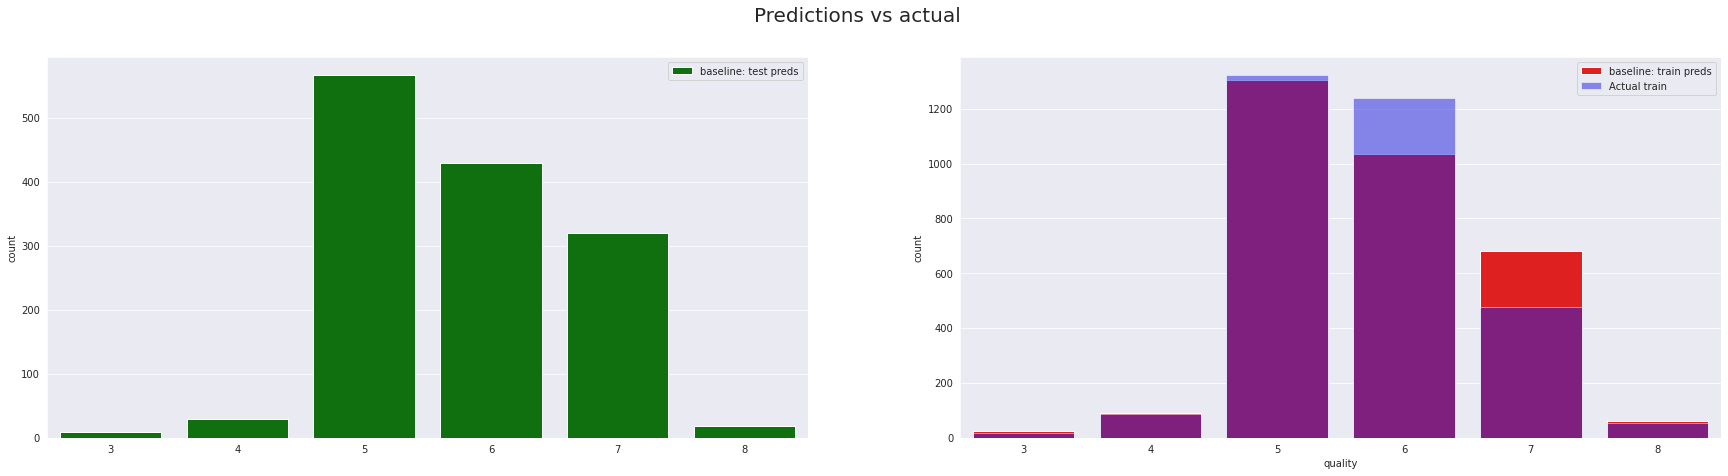

In [42]:
fig, ax = plt.subplots(1,2, figsize = (30,7))
sns.countplot(x =test_base.argmax(axis =1)+3, label = f"baseline: test preds", color ='green', ax= ax[0])
sns.countplot(x =trn_preds_base.argmax(axis =1)+3, label = f"baseline: train preds", color ='red', ax= ax[1])
sns.countplot(x =y+3, label = f"Actual train",alpha =0.5, color ='blue', ax= ax[1])
ax[0].legend()
ax[1].legend()
plt.suptitle("Predictions vs actual", fontsize = 20)
plt.show()

##### NOTE: The model is overpredicting 7 and under prediction 5 and 6
* Can we improve this with some additional features. Lets look at the feature importances and shap values to get some ideas

# ☘️ Feature importance ☘️

## 1. Intrinsic model feature importance
* As we are using lightgbm as our base model we can get an output of the models feature importance. 

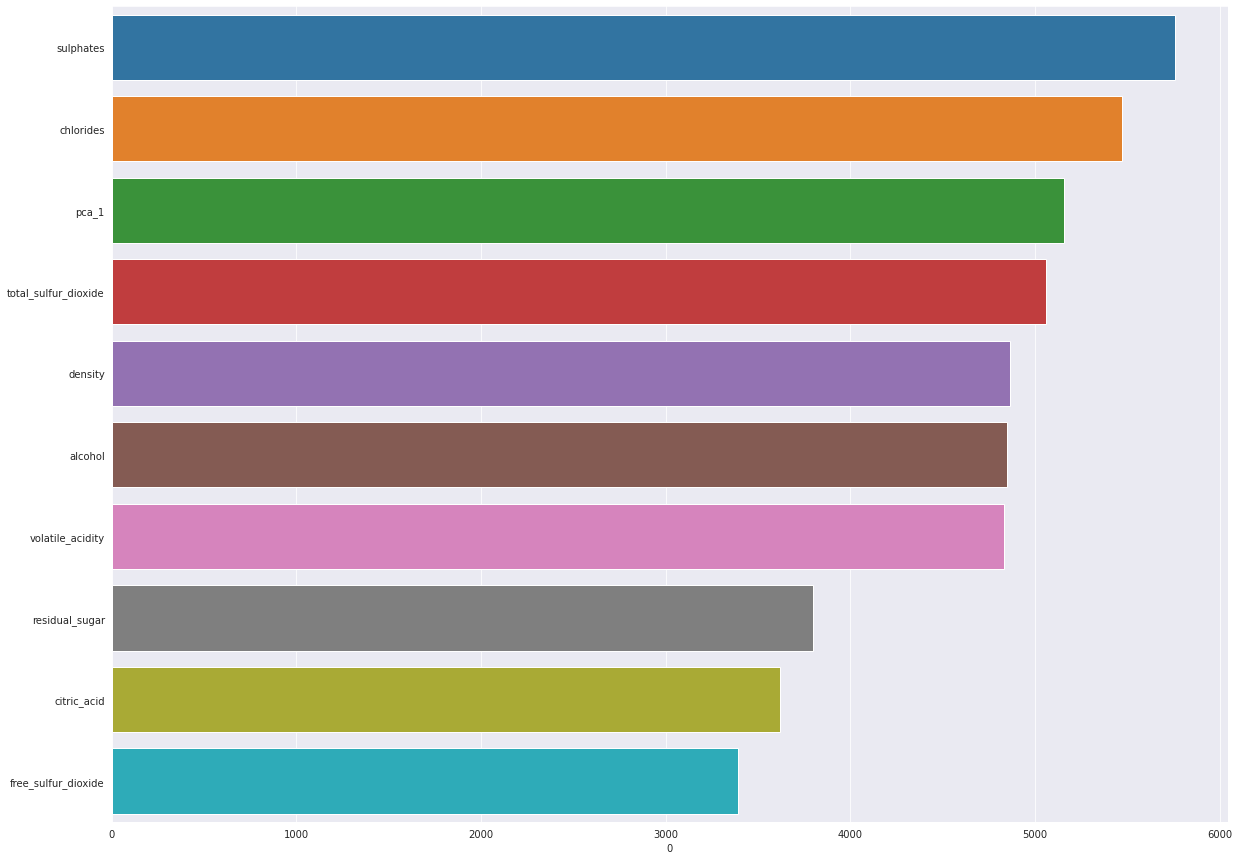

In [43]:
importances = pd.DataFrame(data = model.feature_importances_, index = model.feature_name_).sort_values(ascending = False , by =0)

plt.figure(figsize = (20,15))
sns.barplot(x = importances[0], y= importances.index)
plt.show()

<span style="color:blue;font-size:1.2em;">Notes:  </span>
* **Personal opinion**: intrinsic feature importance of tree based models are poor determinants of the **level of importance** as it looks at information gain. This calculation determines how the data is partitioned into a target value and doesnt neccessarily the determine level of importance 
 * Feature importance is helpful noting **0 important features** as these features werent included in the prediction at all and can be **dropped** 
 * I would ignore the level of importance to a certain degree 

## 2. Shap values 
[Shap values](https://shap.readthedocs.io/en/latest/index.html) are a good indicator of the **degree of feature importance** 
* We use multiple visualization methods to assists when plotting shap values from our fitted model

 
<span style="color:blue;font-size:1.2em;">Notes: Shap Values </span>\
Shape values determine how the prediction was impacted. A **High** Shap value means that the predictive was influenced positively:
i.e. if the output is a probability from 0 to 1
* A high (postive) shap value will increase the prediction towards 1 (denoted as **RED** color)
* A low (negative) shap will decrease the prediction towards 0 (denoted as **BLUE** color

In [44]:
shap.initjs() # for visualization 

#Get Shap values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_s)

<span style="color:orange;font-size:1.8em;">Target Interaction (by shap feature importance) </span>

### Summary Plot
The shap summary plot gives us an indication of feature importance. We need to pay specific attention to features with **high** average shap values as well as those that are zero:
* Zero valued features are good candidates for removal 
* High average shap values are good candidates for feature engineering. We can get ideas for feature engineering by viewing **shap.dependeceplots** and **shap.force_plots** (see below) to see the relationship of features

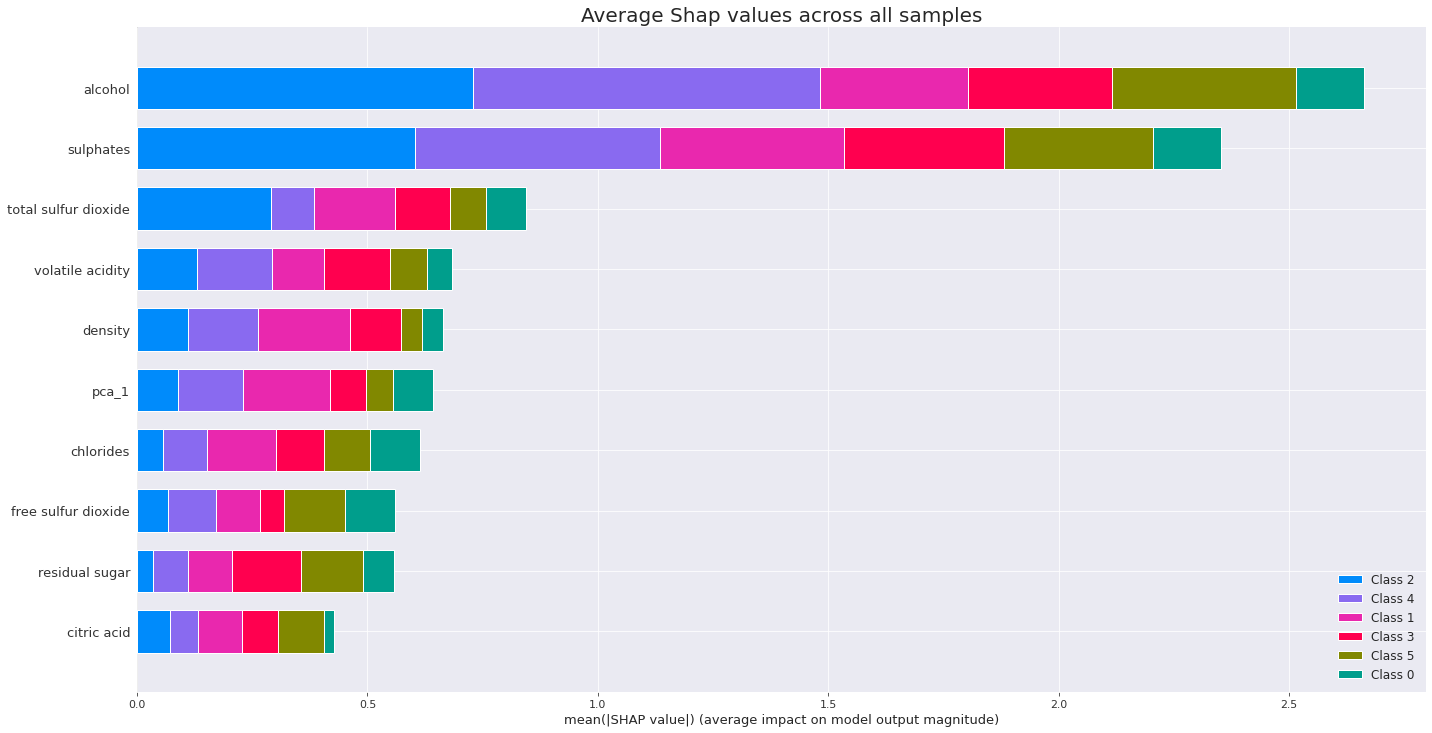

In [45]:
shap.summary_plot(shap_values, X_test_s,max_display = 400, plot_size = [20,10], show= False)
plt.title("Average Shap values across all samples", fontsize = 20)
plt.show()

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


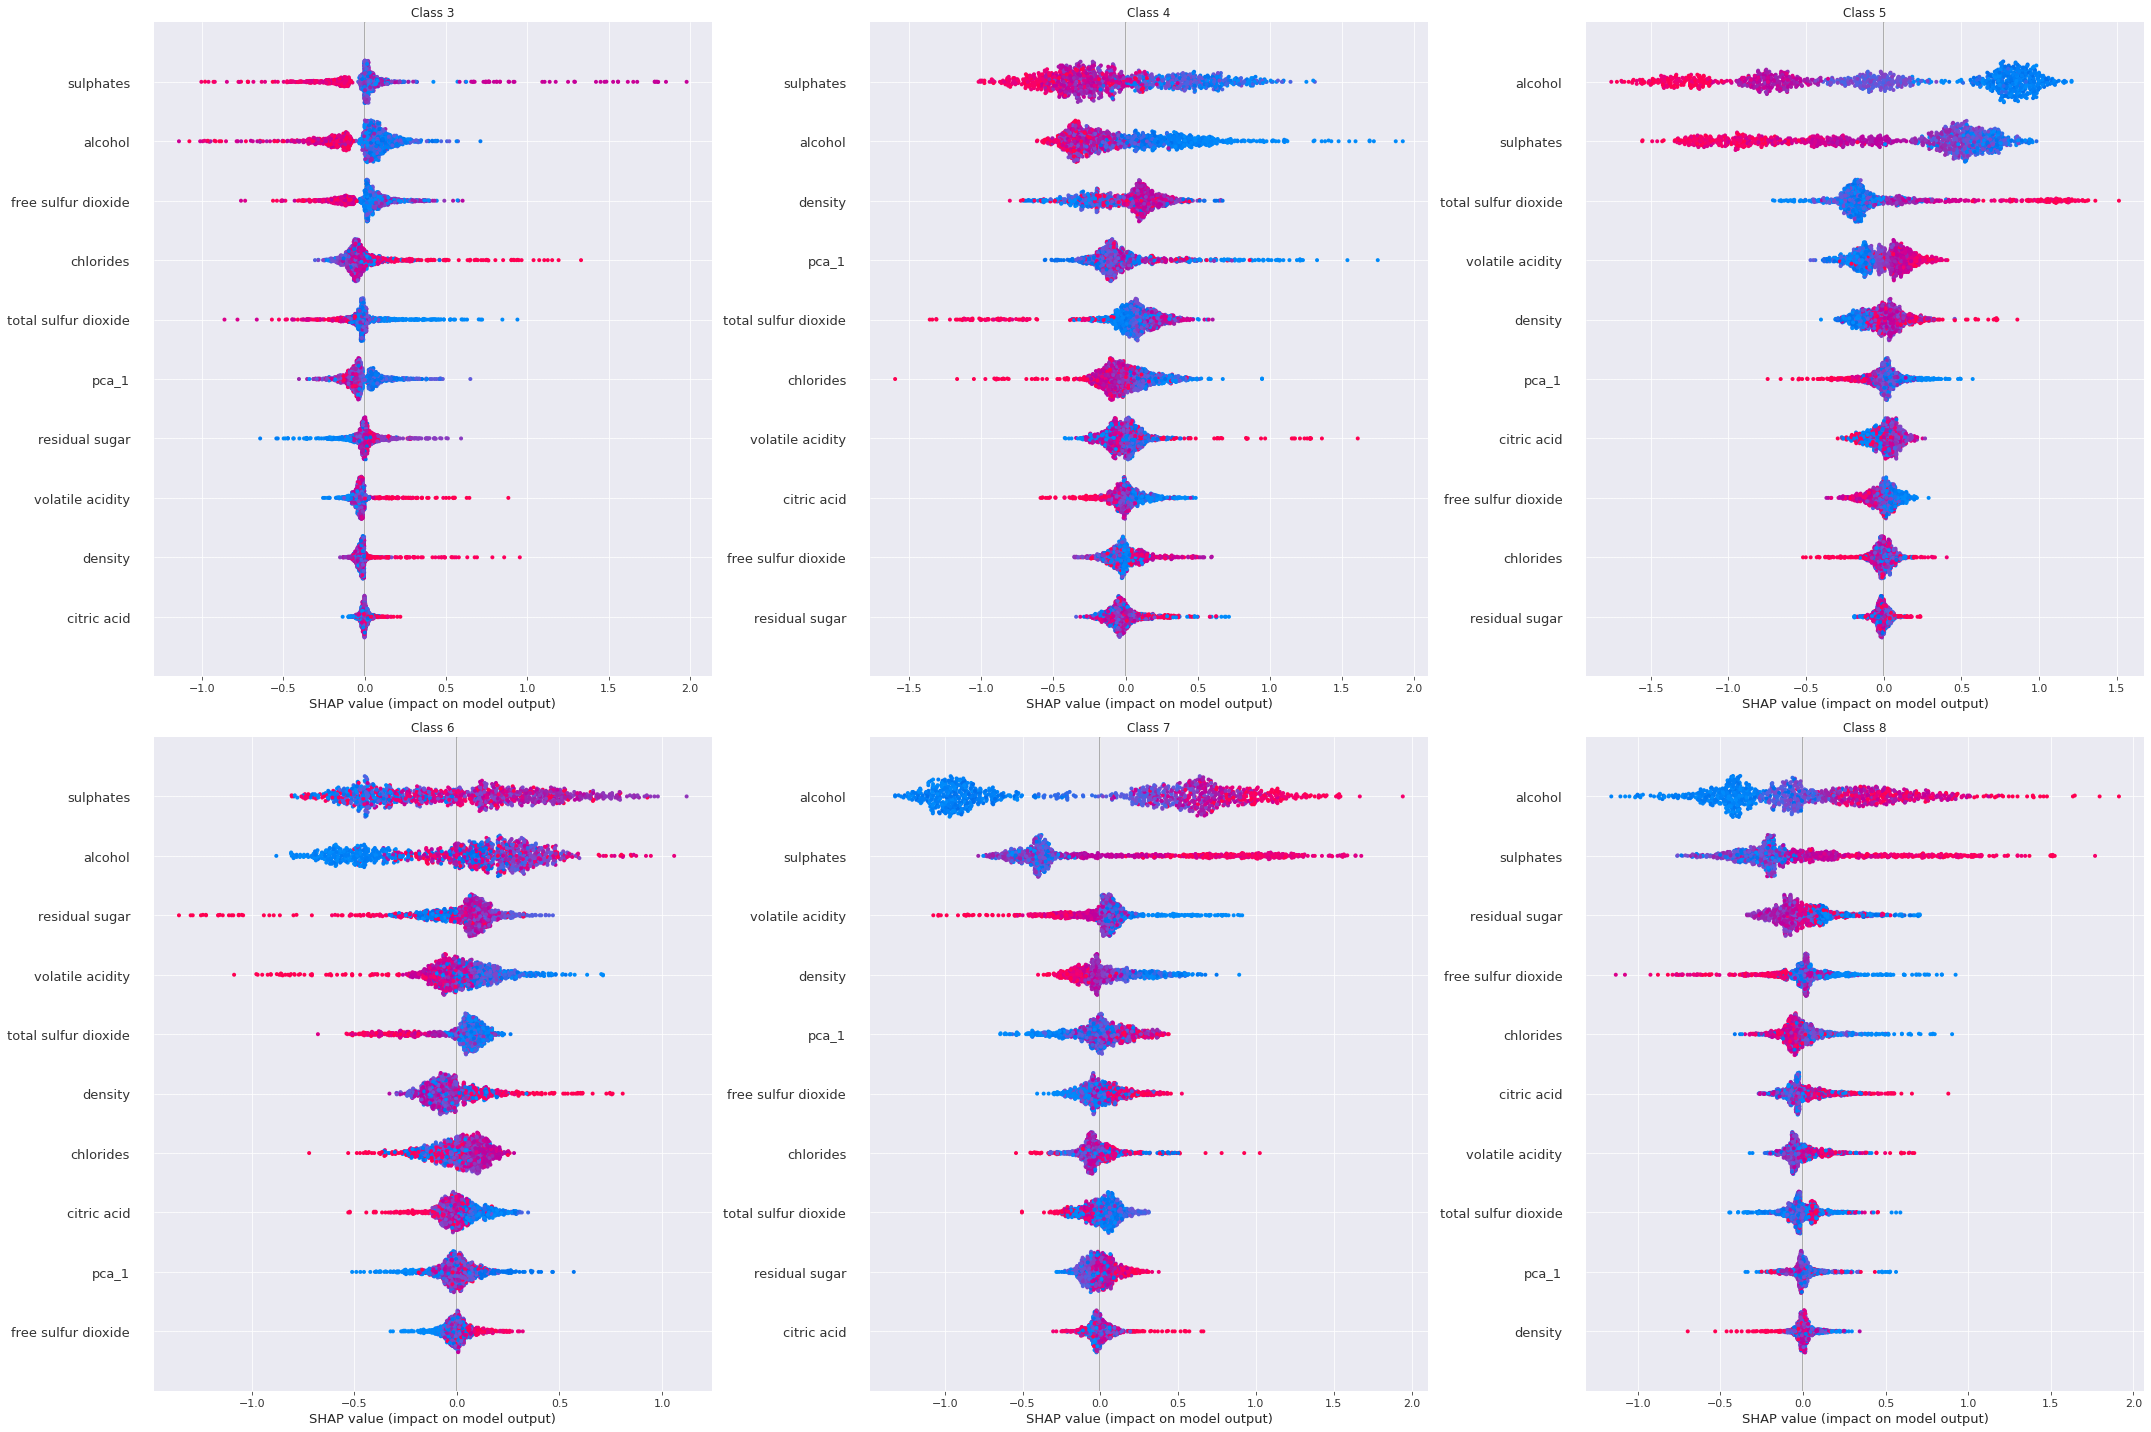

In [46]:
# We can get the shap values for each class by indexing the shap_values i.e shap_values[0] ==Class 0 (remember we need to add 3 to our classes)
fig = plt.figure()
for i in range(len(df_trn[target].unique())):
    ax = fig.add_subplot(231+i)
    shap.summary_plot(shap_values[i], X_test_s,max_display = 400, show= False, color_bar = False)
    ax.set_title(f"Class {i+3}", fontsize =12)
    
plt.gcf().set_size_inches(30,20)
plt.tight_layout()
plt.show()

<span style="color:blue;font-size:1.2em;">Notes: Shap Values </span>
* Certain features may have zero average shap value. As such they dont play a part in the models prediction. 
    * We can test our model again without these features to see if there is a model improvement (i.e. drop  column)
* Additionally, the graphs also give us ideas on new features we can create:
    * i.e. Sulphates is important to all Classes and we can see in the "Class 7" graph that the "points" under sulphates are red as the shap value increases 
        * Can we create a cutoff or filter feature that lets the model know when the sulphates are above a certain level i.e. sulphates > 1.0. This may help it classify Class 7 better

### Force Plot
The forceplot above looks at a number of samples and shows how certain (important) features influenced the final model prediction i.e. How these features push the model to predict the target of 0 or 1

In [47]:
shap.force_plot(explainer.expected_value[1], shap_values[0][0:1,:], X_test_s.iloc[0:1,:])

<span style="color:blue;font-size:1.2em;">Notes: This is plot of 1 sample within our dataset for CLASS 3: </span>
* The **Output value**  is the bold value and is the Shapley value for this sample. It is **negative** so it means that the model is pushing towards a negative result (i.e. towards 0 == not likely to be  Class 3) Note: a positve value would push the model towards 1 (highly likely to be Class 3)
    * This **Output** value is the "raw" value which is then transformed into probability space, to give you the final probability between  0 and 1 (i.e. negative shap means < 0.5 probabiltity).
* The base value:
 * This is the value that would be predicted if we didn’t know any features for the current instance. The base value is the average of the model output over the training dataset
* All **Blue** colored features have a **negative** influence on the models prediction and all **Red** colored features have a **postive** influence. 
 * The Features **closest** to the **Output value** have a higher degree of influence on the prediction (i.e the shap value) 
 * The value associated with each feature shows the sample value (e.g. if 'free sulpher dioxide' = -1.143 that is the value for this sample in the dataset)  

##### This sample is showing that our model is predicting that this samples is not likely to be Class 3

Below is a force_plot of ALL the samples, use the dropdowns on the x and y axis to filter by specific features

In [48]:
shap.force_plot(explainer.expected_value[1], shap_values[0], X_test_s)

<span style="color:blue;font-size:1.2em;">Notes: </span>
* If we set features on the x and y axis. We will see all the shap values for Class 3. i.e. how our model predicts class 3 and its interaction by the features 
 * We can potentially create a new feature from these two features
 
 
 ##### Ill leave it to you to create and investigate force_plots for all the classes 

<span style="color:orange;font-size:1.8em;">Feature Interaction / Feature Dependency </span>
    
Below we look at the interaction and relationship **between features** 

#### Interaction Values
Shap Interaction values are the fantastic as visualizing how features affect others in relation to the models prediction 

In [49]:
# Get interaction values
shap_interaction_values = explainer.shap_interaction_values(X_test_s)

### 1. Heatmap plot of shap interaction values 

Taken from [analysing interactions with shap](https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a):
1. To start we will calculate the absolute mean for each cell across all matrices. 
2. We take the absolute values as we do not want positive and negative SHAP values to offset each other. 
3. Because the interaction effects are halved, we also multiply the off diagonals by 2. 
4. We then display this as a heatmap.

**Note**: As this is a multiclass classification problem we have interaction values for each class i.e. 12 columns = 12 shap interaction values 

#### 1a Absolute mean shap interactions 
* We get the **absolute mean** of the shap interactions 
 * the absolute of the values gives us the magnitude of the interaction and includes both negative and postive probability (i.e. adds them together as positives) 
 * if we want the overall result , we must remove the absolute calculation and only calculate the mean shap interactions 

In [50]:
# Get absolute mean of matrices
abs_mean_shap = np.abs(shap_interaction_values).mean(axis =1)

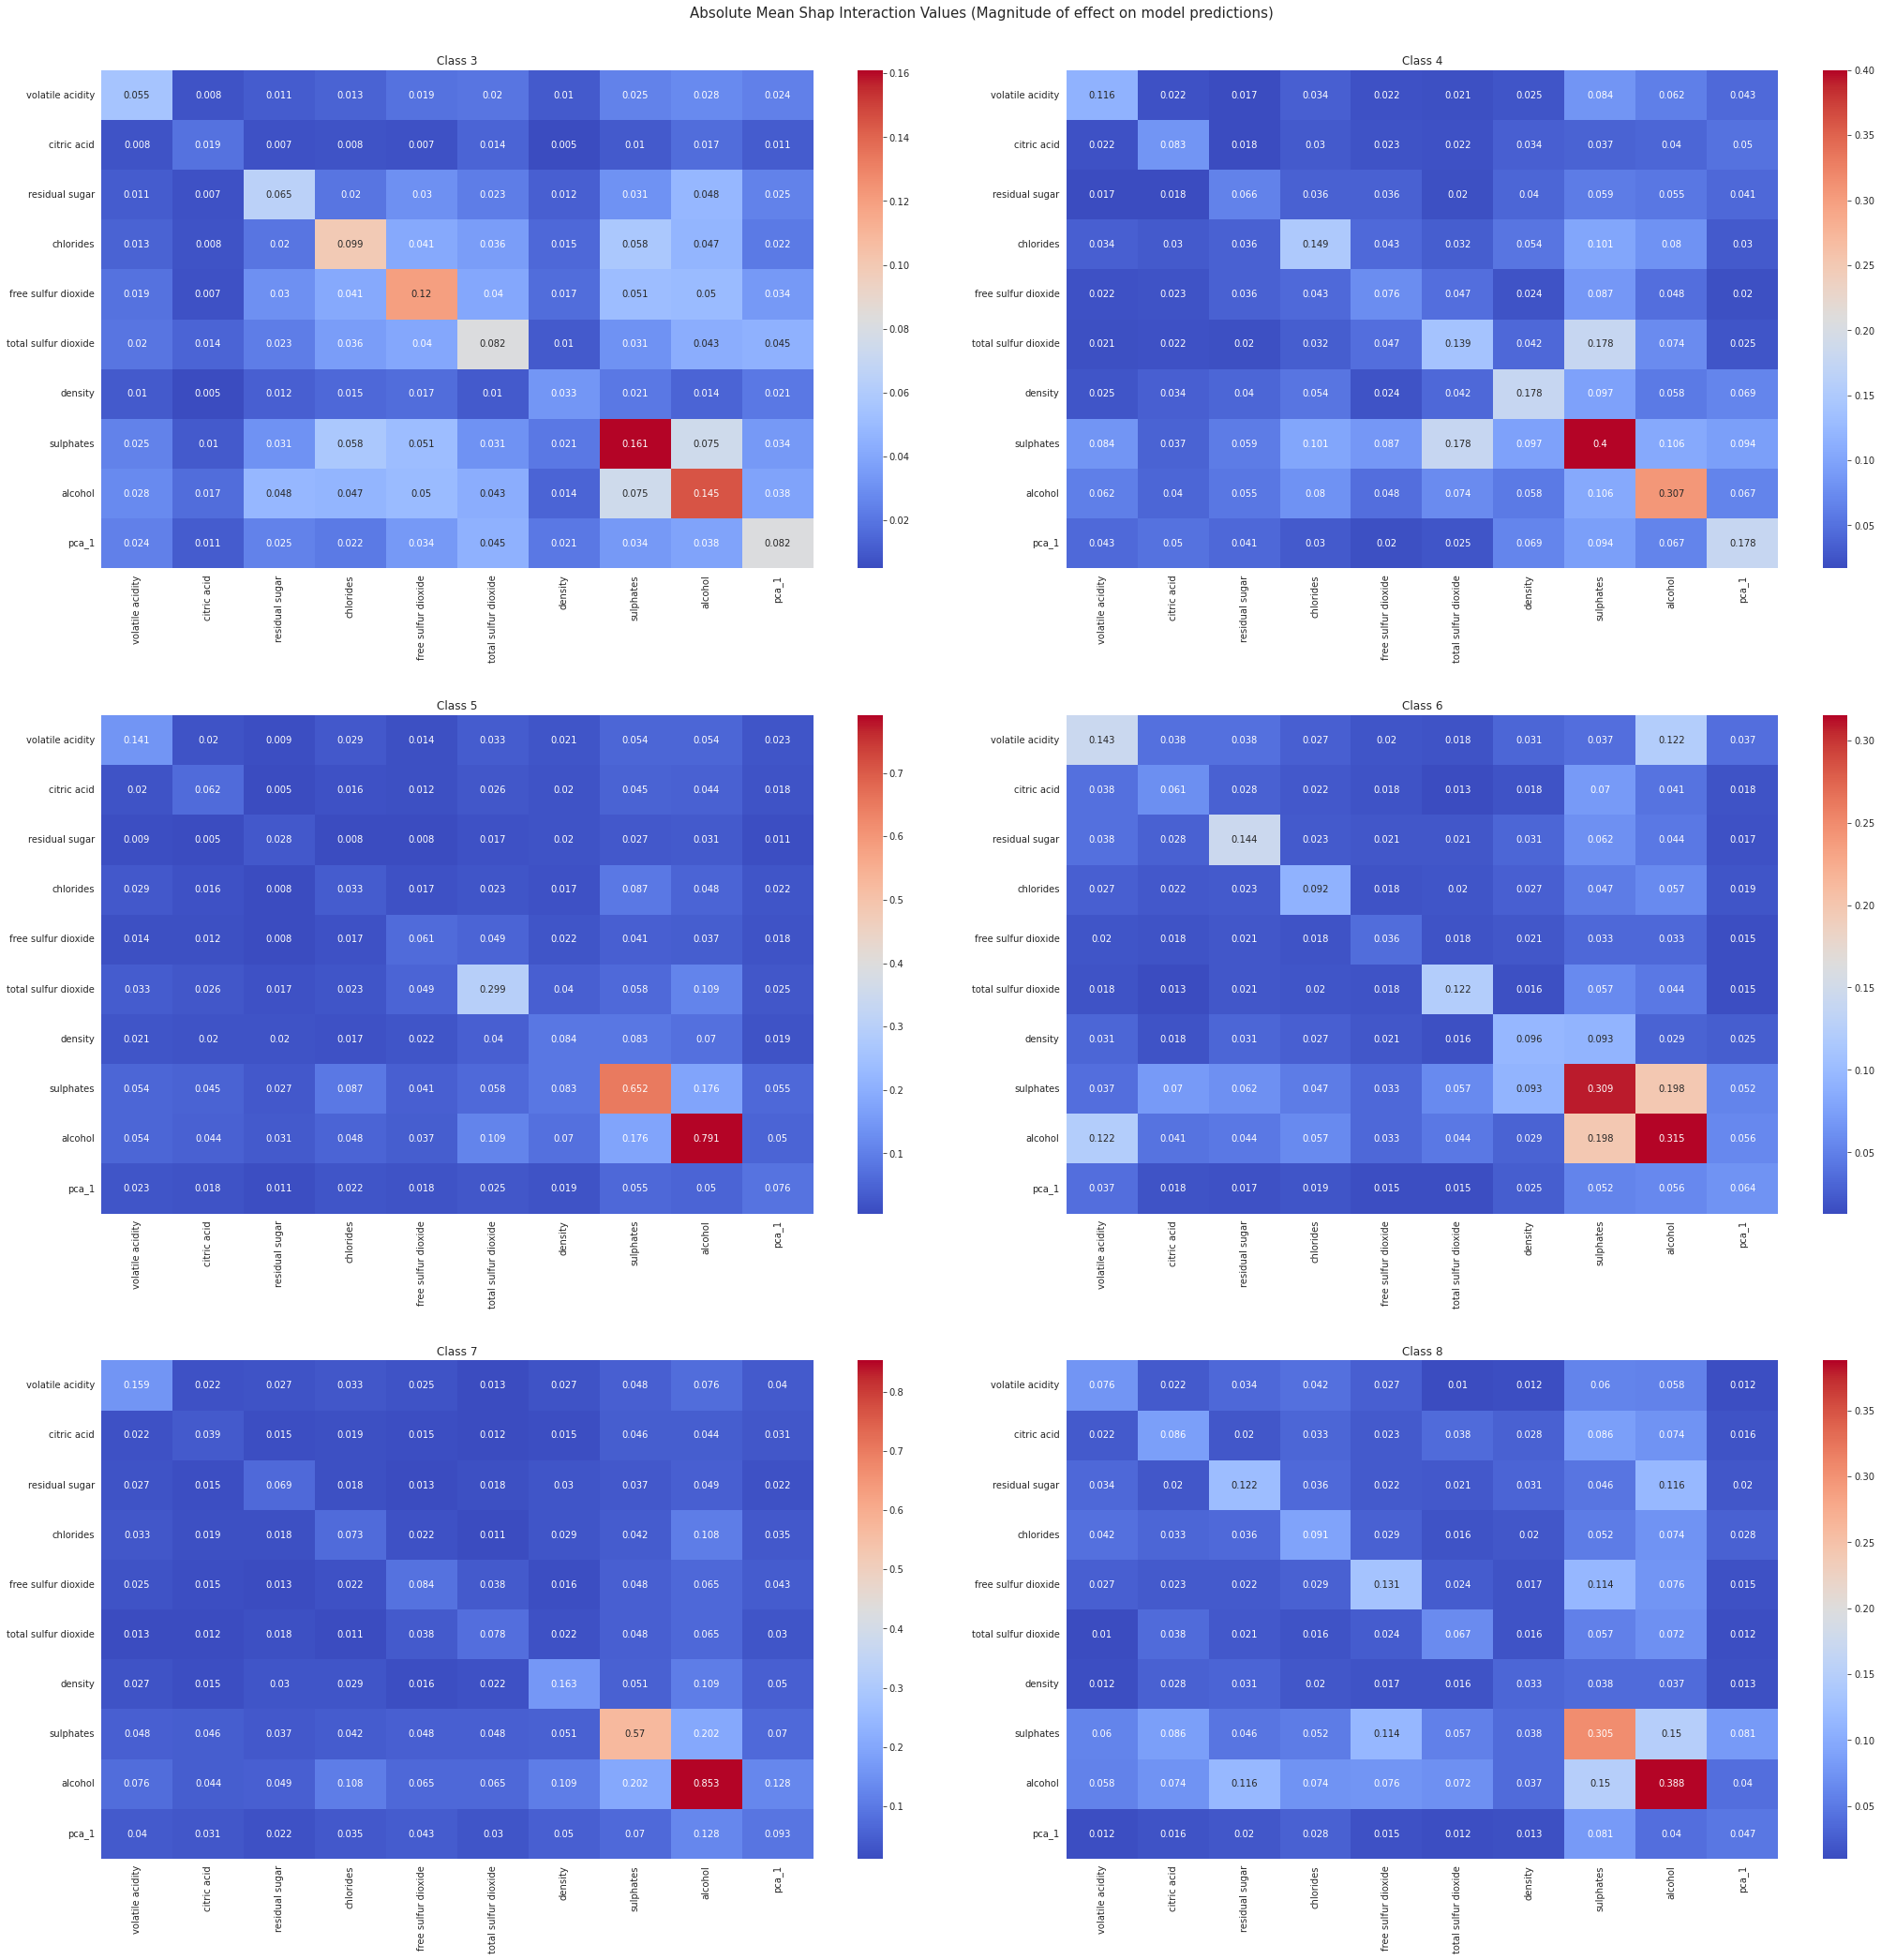

In [51]:
fig,ax = plt.subplots(3,2, figsize = (30, 30)) 
ax = np.ravel(ax)

for i in range(len(abs_mean_shap)):
    df = pd.DataFrame(abs_mean_shap[i], index=X_test_s.columns, columns=X_test_s.columns)
    df.where(df.values == np.diagonal(df),df.values*2, inplace=True)
    sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=True, ax=ax[i]   )
    
    ax[i].tick_params(axis='x', labelsize=10, rotation=90)
    ax[i].tick_params(axis='y',  labelsize=10)
    ax[i].set_title(f"Class {i+3}")
plt.suptitle("Absolute Mean Shap Interaction Values (Magnitude of effect on model predictions)",fontsize=15)
plt.tight_layout(pad = 4)
plt.show()

#### 1b Mean shap interactions 
* Gives us the feature interaction value that and the overall push that these features have on the models prediction i.e. red = high probability of class 

In [52]:
# Get absolute mean of matrices
mean_shap = np.array(shap_interaction_values).mean(axis =1)

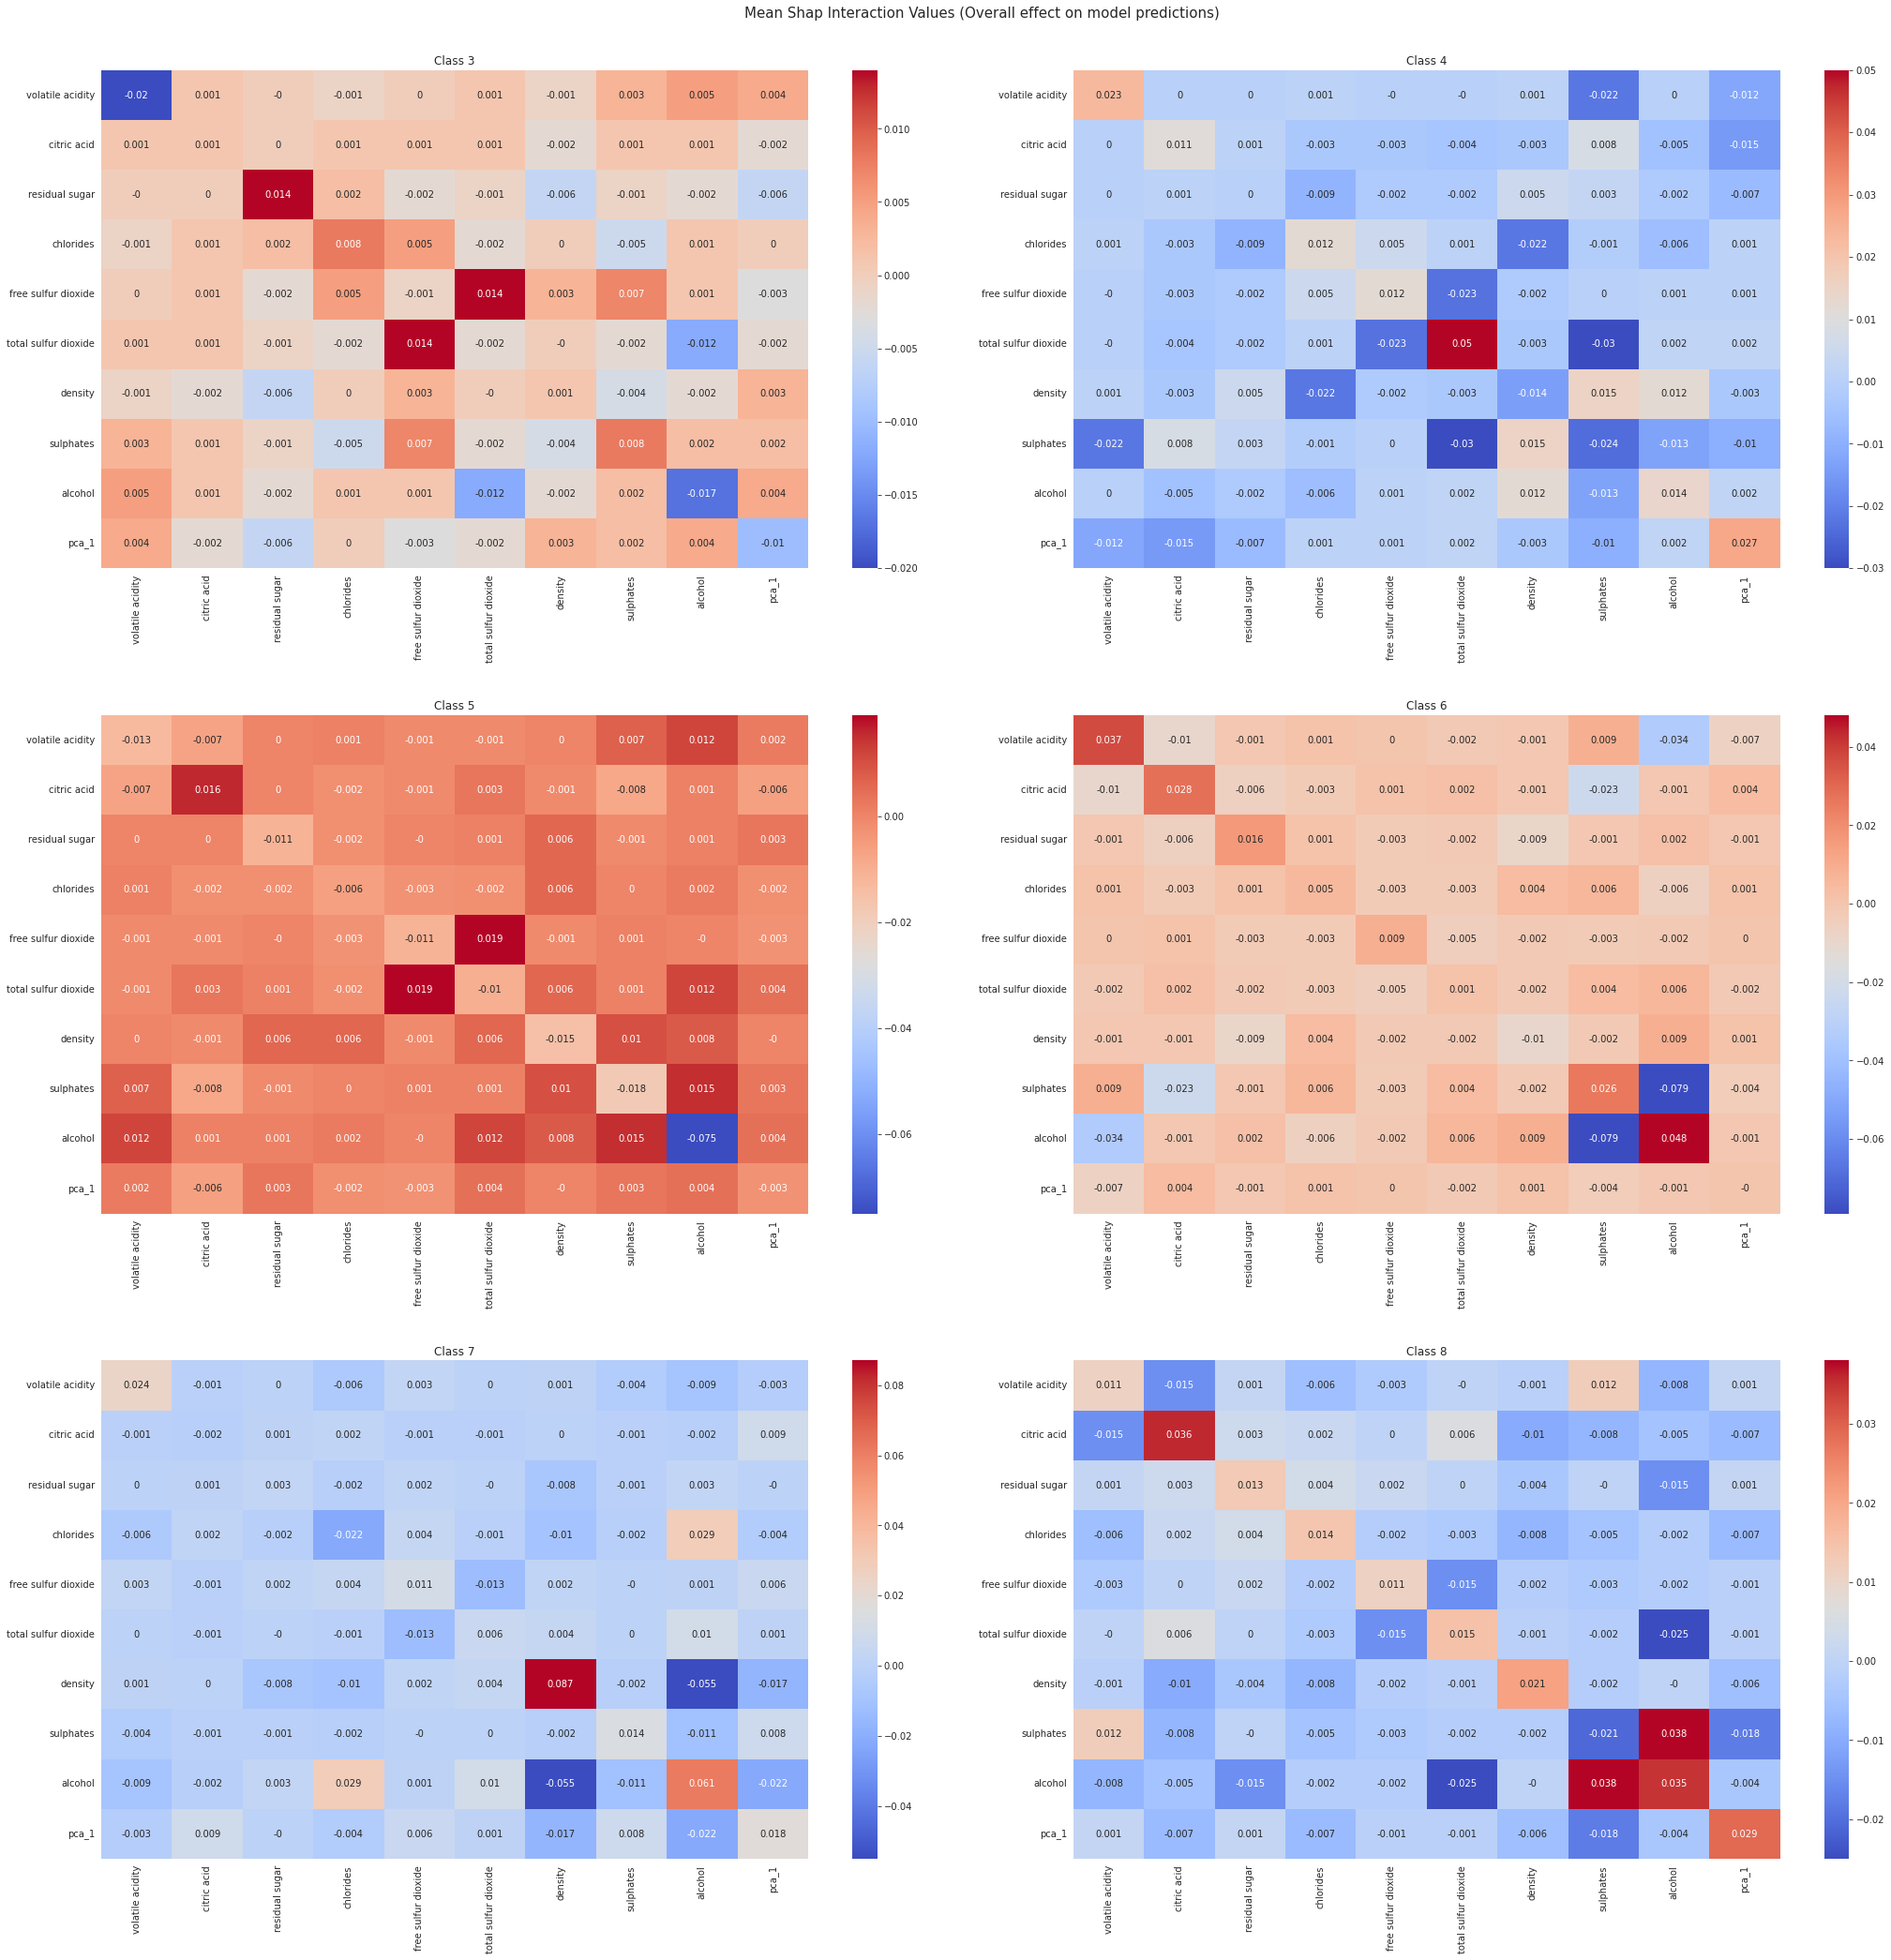

In [53]:
fig,ax = plt.subplots(3,2, figsize = (30, 30)) 
ax = np.ravel(ax)

for i in range(len(mean_shap)):
    df = pd.DataFrame(mean_shap[i], index=X_test_s.columns, columns=X_test_s.columns)
    df.where(df.values == np.diagonal(df),df.values*2, inplace=True)
    sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=True, ax=ax[i]   )
    
    ax[i].tick_params(axis='x', labelsize=10, rotation=90)
    ax[i].tick_params(axis='y',  labelsize=10)
    ax[i].set_title(f"Class {i+3}")
plt.suptitle("Mean Shap Interaction Values (Overall effect on model predictions)",fontsize=15)
plt.tight_layout(pad = 4)
plt.show()

<span style="color:blue;font-size:1.2em;">Notes: </span>
* from the above graphs we can see that there is a large interaction between 'sulphates' and 'alcohol' 
 * We could create a new feature to exploit this i.e. sulphates x alcohol

#### Dependence plots
* Dependence plots require a lot of investigation and testing. We look at the relationship of 2 features and how they influence the **shap values** (i.e. the model output)
* Below I took a feature with a high average Shap value (see summary plot i.e. alcohol) and look at its relationship with features that interact highly with it (see heatmaps above). This will hopefully allow us to find any additional feature we can create (i.e clip values, multiply/Add/Subtract features , polynomial features etc) 

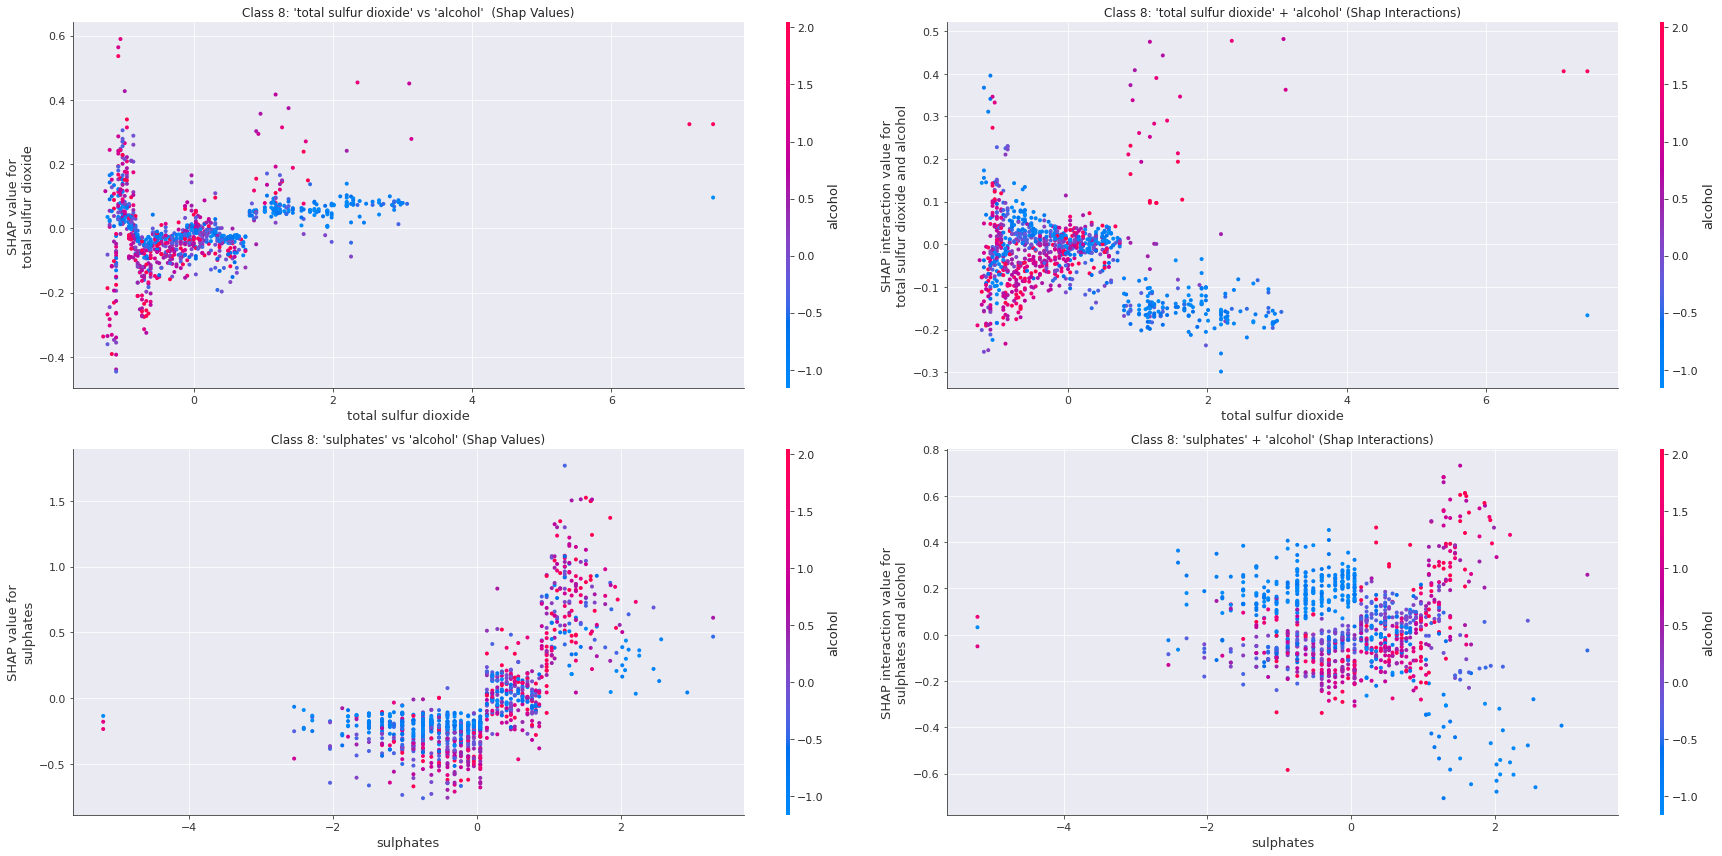

In [54]:
fig = plt.figure()
ax0 = fig.add_subplot(2,2,1)
shap.dependence_plot("total sulfur dioxide", shap_values[5], X_test_s, display_features=X_test_s, interaction_index="alcohol", show=False,ax= ax0)
ax0.set_title("Class 8: 'total sulfur dioxide' vs 'alcohol'  (Shap Values)" )
ax1 = fig.add_subplot(2,2,2)
shap.dependence_plot( ( "total sulfur dioxide","alcohol"),  shap_interaction_values[5], X_test_s, display_features=X_test, show=False, ax= ax1)
ax1.set_title("Class 8: 'total sulfur dioxide' + 'alcohol' (Shap Interactions)" )

ax2 = fig.add_subplot(2,2,3)
shap.dependence_plot("sulphates", shap_values[5], X_test_s, display_features=X_test_s, interaction_index="alcohol", show=False,ax= ax2)
ax2.set_title("Class 8: 'sulphates' vs 'alcohol' (Shap Values)" )
ax3 = fig.add_subplot(2,2,4)
shap.dependence_plot(  ("sulphates","alcohol"),  shap_interaction_values[5], X_test_s, display_features=X_test, show=False, ax= ax3)
ax3.set_title("Class 8: 'sulphates' + 'alcohol' (Shap Interactions)" ) 

plt.gcf().set_size_inches(25,12)
plt.tight_layout()
plt.show()

<span style="color:blue;font-size:1.2em;">Notes: We want to isolate High/Low  Shap values </span>
* These shap values arent giving us much to work with as there isnt a clear clump of color or seperate of values by shap value

##### Let Shap find the most important interactions:
* using shap.approximate_interactions, this will provide other feature indexes that significantly affect the shap value. 

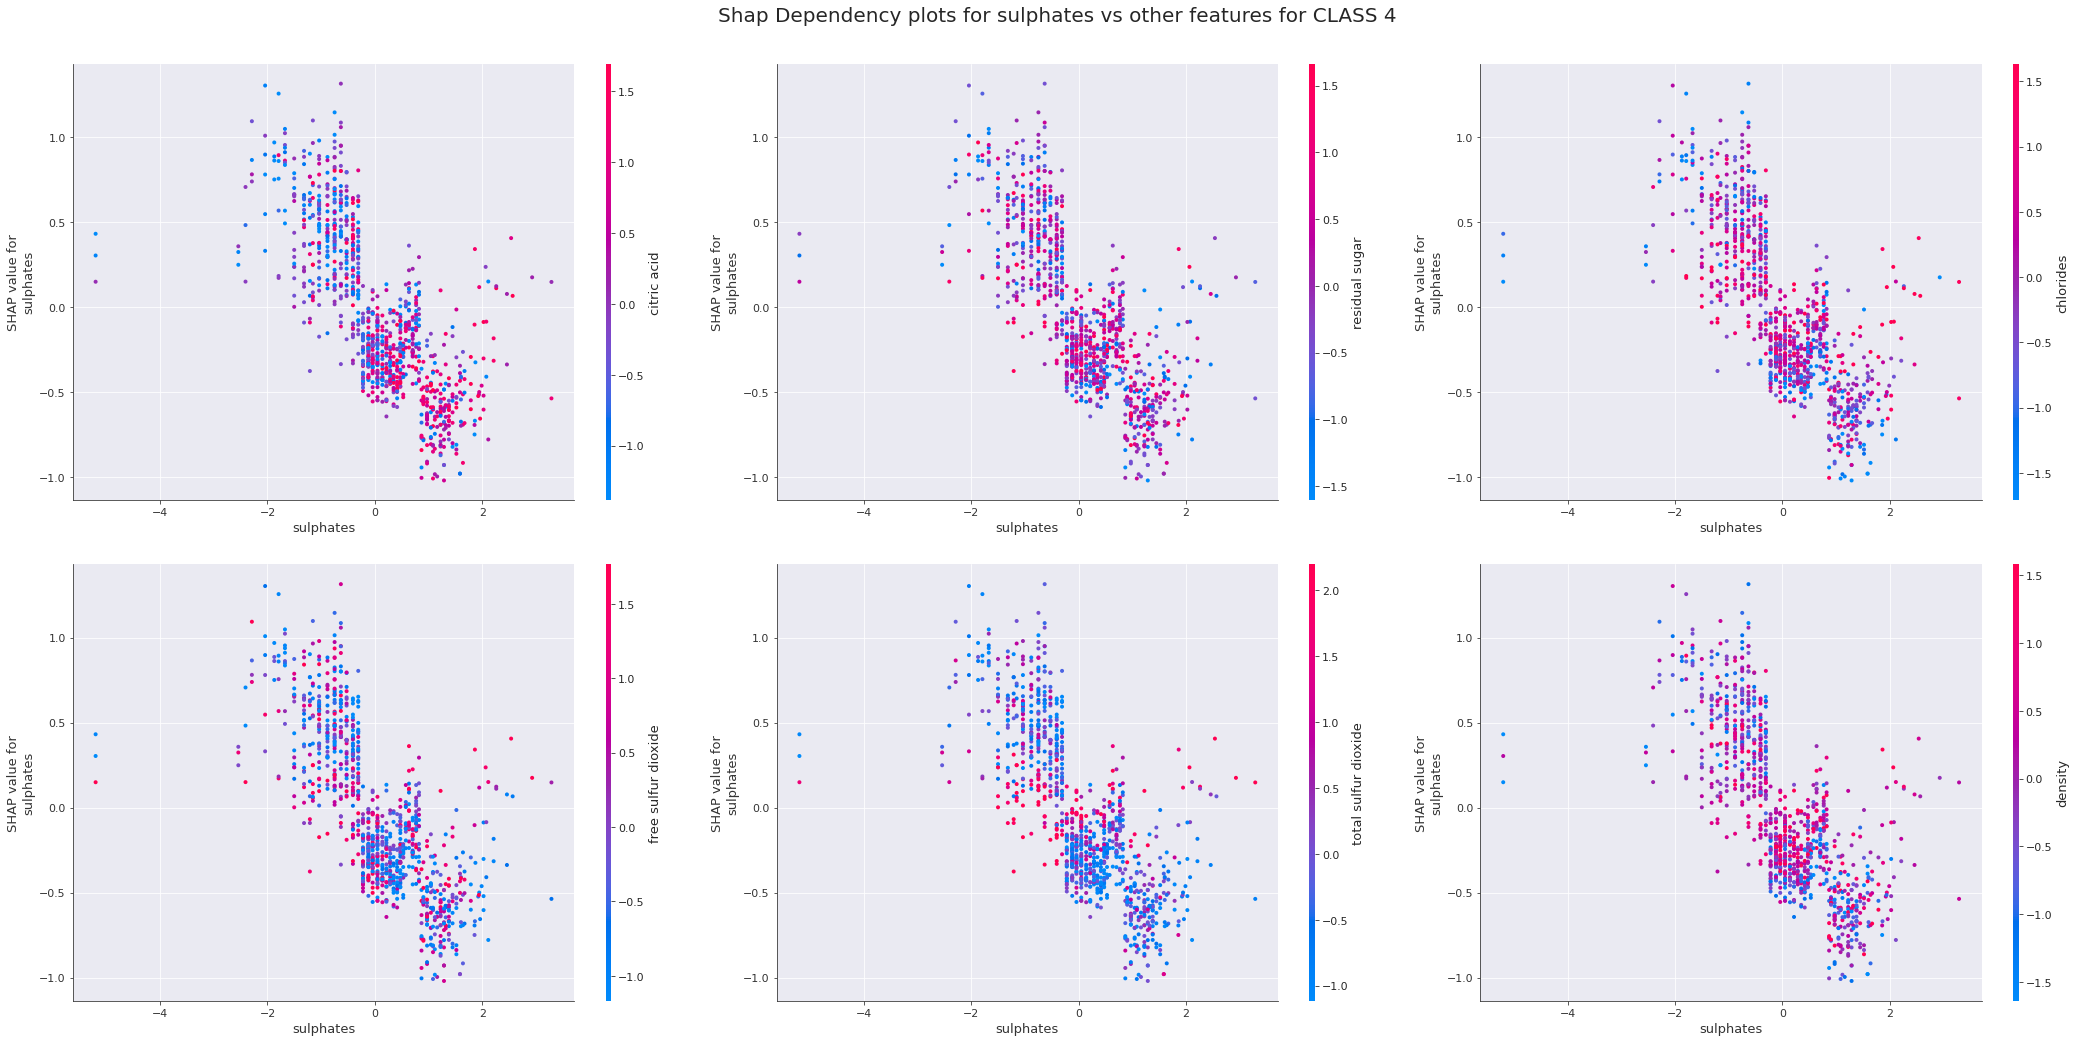

In [55]:
fig = plt.figure()
for i in range(1,7):
    axes = fig.add_subplot(2,3,i)
    shap.dependence_plot("sulphates", shap_values[1], X_test_s, display_features=X_test_s, interaction_index=i, show=False,ax= axes)
plt.gcf().set_size_inches(30,15)
fig.suptitle("Shap Dependency plots for sulphates vs other features for CLASS 4", fontsize = 20)
plt.tight_layout(pad =3)
plt.show()

<span style="color:blue;font-size:1.2em;">Notes: We want to isolate /Low  Shap values </span> 
* NOTE: These values have been scaled so they wont make sense when comparing to the training data 

# 🧊  Muti-Model Testing 🧊 
In this section we will test multiple models. This will allow use to understand which model would be best to optimize as well as allow use to ensemble models once optimized (note that we dont optimize the models in this notebook) 
The models we test should be quite broad however we can lump these into 3 categories:
* Linear i.e. Logistic regression for general linear modelling, Ridge when we dnt have optimal features selected (Ridge regularizes features) and Support Vector Machines for additional kernalization
* Trees i.e. gradient boosting such as LightGBM and XGBoost with ensemble trees convered by Random Forests and Extra Trees  
* Neural networks (see below)

**On Neural network exclusion**:\
As this is a tabular problem (not an image or text based) I will assume that neural networks wont do as well for this problem. This is also quickly apparent when looking at the data which is not homogenous in nature (i.e similar distributions, scale and source) this is usually an indicator that Neural networks wont do well with this problem 
Also due to their long run time and complexity I will note include here 


Due to an imbalanced dataset we want to create a dictionary of all our class weights and pass this to models that allow for this. Note that we use this for catboost only as the other models work better with the "balanced" parameter

In [56]:
weights = df_trn[target].value_counts().sort_index()
weights = weights.astype(float)
for i in range(len(weights)):
    #weights[i] = len(df_trn) / (len(weights) * weights[i])
    weights[i] = 1-  (weights[i] / len(df_trn))
weights= weights.to_dict()
print("Catboost class weights:\n")
weights

Catboost class weights:



{0: 0.9943732416380119,
 1: 0.9724914035636136,
 2: 0.5867458580806502,
 3: 0.6123788683963738,
 4: 0.8512035010940919,
 5: 0.9828071272272585}

In [57]:
xgb_params = { 
    'objective' : "multi:softproba",
    'num_class' : 6,
    'n_estimators' : EPOCHS, 
    'early_stopping_rounds' :30,
    #'custom_metric':kappa_score,
    #'scale_pos_weight':weights
             }
cat_params = {'iterations':EPOCHS,
               'class_weights' : weights,
              #'eval_metric' : kappa_score,  ## Need to fix this doesnt work 
              'learning_rate': 0.01,
              'loss_function':'MultiClass'
             }
ET_params = {'max_depth':6, 'num_iterations':EPOCHS}
RF_params = {'class_weight' : 'balanced',  'max_depth':8,'n_estimators':EPOCHS,
            }

In [58]:
# Comment out the models below to include in the Crossvalidation 

models = {
      "LogisticRegression": LogisticRegression(max_iter = EPOCHS),
    "SVC":SVC(probability=True, kernel = "rbf",class_weight='balanced',max_iter = EPOCHS),
     "lightgbm": lgb.LGBMClassifier(**lgb_params), 
    "xgboost": xgb.XGBClassifier(**xgb_params), 
    "catboost": cat.CatBoostClassifier(**cat_params),
     "ExtraTreeClassifier": ExtraTreesClassifier(),
     "RandomForestClassifier":RandomForestClassifier(**RF_params)
}

## Cross Validation

In [59]:
# We use Stratified Kfold due to the class imbalance
kfold= StratifiedKFold(n_splits=5)

In [60]:
test_preds =[]
train_preds = []
val_preds = []
model_shap_values = []

OOF_val_score =[]
OOF_val_loss =[]

for name,model in models.items():
    score_train = []
    score_val= []
    score_loss = []
    
    #Shap stuff
    list_shap_values = []
    val_index = []
    
    in_fold_trn_preds = []   
    in_fold_val_preds= []
    in_fold_preds = []
    print("\n######",name,"######")

    for fold, (train_idx,val_idx) in enumerate(kfold.split(X,y)):
        X_train,y_train = X.iloc[train_idx,:], y.iloc[train_idx]
        X_test,y_test = X.iloc[val_idx,:], y.iloc[val_idx]
        val_index.extend(val_idx)
        
        #Scaling
        if name in ["LogisticRegression",'Ridge', "SVC"]:
            scaler = StandardScaler()
            X_train_s = scaler.fit_transform(X_train)
            X_test_s  = scaler.transform(X_test)
            X_temp = X.copy(deep = True)
            X_temp = scaler.transform(X_temp)
            test_temp = scaler.transform(df_tst)
            y_train_s = y_train.copy(deep = True)
        else:
            X_train_s, X_test_s , test_temp, X_temp, y_train_s = Scaling(X_train, X_test , df_tst, y_train, X )
            
                   
        #Fit
        if name in ["lightgbm"]:
            model.fit(X_train_s,y_train_s,
                      eval_set=[(X_test_s,y_test)],
                      eval_metric=kappa_score,
                      callbacks= [lgb.log_evaluation(-1), lgb.early_stopping(30)])
            
        if name in ["xgboost"]:
            model.fit(X_train_s,y_train_s,
                     eval_set=[(X_test_s,y_test)],
                      verbose= 0
                     )
        elif name in ["catboost"]:
            model.fit(X_train_s,y_train_s,
                      eval_set=[(X_test_s,y_test)],
                      #eval_metric=kappa_score(),
                      early_stopping_rounds=30,
                      verbose= 0
                     )          
        else:
            model.fit(X_train_s,y_train_s)
            
        # Predict
        y_preds = model.predict_proba(X_test_s)
        val_score= cohen_kappa_score(y_test, y_preds.argmax(axis =1), weights ='quadratic' )
        in_fold_val_preds.extend(y_preds)
        
        #remove low scoring models 
        if val_score >THRESHOLD:
            y_trn_preds = model.predict_proba(X_temp)
            score_val.append(val_score)
            score_train.append(cohen_kappa_score(y, y_trn_preds.argmax(axis =1), weights ='quadratic'))
            score_loss.append(log_loss(y_test, y_preds))
            in_fold_trn_preds.append(y_trn_preds )

            in_fold_preds.append(model.predict_proba(test_temp) )
    
    if len(score_val)>0:
        OOF_val_score.append(np.mean(score_val))
        OOF_val_loss.append(np.mean(score_loss))
        train_preds.append(np.mean(in_fold_trn_preds,axis=0))
        val_preds.append(in_fold_val_preds)
        test_preds.append(np.mean(in_fold_preds,axis=0))

    print("MEAN Trn AUC:",np.mean(score_train))
    print("MEAN Val AUC:",np.mean(score_val))
    print("MEAN logloss:",np.mean(score_loss))


###### LogisticRegression ######
MEAN Trn AUC: 0.47055812467963737
MEAN Val AUC: 0.4809239869269761
MEAN logloss: 1.0115844176066058

###### SVC ######
MEAN Trn AUC: 0.5247551586264383
MEAN Val AUC: 0.46729286637802936
MEAN logloss: 1.0167974297234443

###### lightgbm ######
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 1.30292	valid_0's kappa_score: 0.509108
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] bagging_fraction i

<span style="color:blue;font-size:1.5em;">Notes: Optimizing Models & Score</span>
* We  look at both the kappa_score score for the **validation** set (i.e. X_test) and for the **training** set (i.e. X_train) to identify  **over or underfitting**

<span style="color:red;font-size:1.3em;">Potential Solutions: Over/Underfitting </span>
1. **Overfitting:** The train score will be much larger than the validation score. There will be significant overfitting if the train score is close to 1 (i.e the model has over learnt the training data)
  * Solution: [Reduce overfitting](https://medium.com/geekculture/how-to-stop-overfitting-your-ml-and-deep-learning-models-bb8324ace80b) such as implementing regularization, add data, feature engineering etc 

2. **Underfitting:** If validation score is much lower than training. i.e there is a significant gap 
  * Solution: Hyperparameter tuning and feature engineering (quick improvements would be to increase the number of epochs and  lower learning rate) 

<span style="color:blue;font-size:1em;"> Final Note: I will not optimize each model. I will leave this as homework for anyone to try: </span>
* [Optuna optimization](https://optuna.org/)
* [GridSearch ](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* Manual trial and error

## Setup submissions 

In [61]:
sub[target]  = 0
sub_base =  sub.copy(deep= True)
sub_ensemble = sub.copy(deep= True)
sub_best_cv = sub.copy(deep= True)
sub_cal = sub.copy(deep = True)
mean_ensemble = sub.copy(deep = True)
mode_ensemble = sub.copy(deep = True)
hard_ensemble = sub.copy(deep = True)

In [62]:
# Base model submission
sub_base[target]=test_base.argmax(axis = 1)
print("Base Model (lightgbm) values (inital 5 rows):")
sub_base = sub_base + 3
sub_base.to_csv("submission_base.csv")
sub_base.head()

Base Model (lightgbm) values (inital 5 rows):


quality
Id           
2056        5
2057        5
2058        5
2059        6
2060        6

In [63]:
# Best CV model submission 
sub_best_cv_trn = y.copy(deep = True)
sub_best_cv_trn = train_preds[np.argmax(OOF_val_score)].argmax(axis = 1)
sub_best_cv_trn = sub_best_cv_trn+3

sub_best_cv[target] = test_preds[np.argmax(OOF_val_score)].argmax(axis = 1)
print(f"Best CV model: {list(models)[np.argmax(OOF_val_score)]}")
print("Inital 5 rows")
sub_best_cv = sub_best_cv+3
sub_best_cv.to_csv("sub_best_cv.csv")
sub_best_cv.head()

Best CV model: RandomForestClassifier
Inital 5 rows


quality
Id           
2056        5
2057        6
2058        5
2059        6
2060        6

<span style="color:blue;font-size:1.5em;">Question: Why did Random Forest do well </span>\
Now that we can see our Cross Validation scores we can get an insight into how certain Algorithms work with our data
* We know that Random Forest does **boostrapping** of samples and **feature selection**, therefore we can deduce that either:
 * Certain features are negatively affecting our models performance (as all features are used in lightgbm and xgboost)
 * Certain samples are negatively affecting our models performance i.e. outliers 
 
<span style="color:red;font-size:1.3em;">Potential Solutions: Improving model performance </span>
* Determine if Random Forest is impacted by bootstrapping or features selected
 * Boostrapping: check our scaling and distribution techniques to make sure we are identifying outliers. Also add better features 
 * Features selected: decomposition of features through dropping features and PCA of correlated features
 

# 🥣 Ensembling 🥣
There are a number of ensembling techniques and I will state below my most used:
1. <span style="color:orange;font-size:1em;">Mode, Hard Voting, Soft Voting Ensemble</span>
2. <span style="color:orange;font-size:1em;">Weighted Average Ensemble</span> 
3. <span style="color:orange;font-size:1em;">Hill Climbing</span> ==> iterative process: adding predictions to others and multipling by random weights to find the best (**Note:** This can be quite complicated and I do use this process in this notebook) 
4. <span style="color:orange;font-size:1em;">Optimization methods</span> ==> Similar to High Climbing however it uses specialised optimization algorithms (please see link bellow on how to implement)

More on how these are implemented please check out my [notebook here ](https://www.kaggle.com/code/slythe/post-ensembling-hill-climbing-weighted-scipy)

### Mode vs Hard and Soft Voting
As we are looking at a multi-class classification problem. We can ensemble a few other ways such as 
* Mode: Get the **most frequent prediction** from all the models i.e. four models predicted the class as 3 and two models predicted the class as 1, therefore we use class 3 (most frequent) 
* Soft-Voting (also called Mean Ensembling): Sum all the **probabilities** and divide by the number of models to get the **mean probabilities**
 * This is only effective if the models are optimized (which ours arent) 
* Hard Voting: Identify the **highest probability** accross all models, this is the prediction 
    * This is usually better than Soft-voting when model are NOT optimized by less so if they models are optimized 

In [64]:
# Get a dataframe of train and test predictions 
all_trn_preds = pd.DataFrame(index = df_trn.index)
all_tst_preds = pd.DataFrame(index = df_tst.index)

for i, preds in enumerate(train_preds):
    all_trn_preds[f"{list(models.keys())[i]}_{OOF_val_score[i]}"] = train_preds[i].argmax(axis=1)
    all_tst_preds[f"{list(models.keys())[i]}_{OOF_val_score[i]}"] = test_preds[i].argmax(axis=1)
all_tst_preds = all_tst_preds+3
all_tst_preds

LogisticRegression_0.4809239869269761  SVC_0.46729286637802936  \
Id                                                                     
2056                                      5                        5   
2057                                      5                        5   
2058                                      5                        5   
2059                                      6                        6   
2060                                      6                        6   
...                                     ...                      ...   
3423                                      5                        5   
3424                                      7                        6   
3425                                      5                        5   
3426                                      5                        5   
3427                                      5                        5   

      lightgbm_0.4670767040627811  xgboost_0.4641613773019725  \
Id                                                              
2056                            6                           6   
2057                            5                           6   
2058                            6                           6   
2059                            6                           6   
2060                            5                           6   
...                           ...                         ...   
3423                            5                           5   
3424                            7                           7   
3425                            5                           5   
3426                            5                           5   
3427                            5                           5   

      catboost_0.5190382788784687  ExtraTreeClassifier_0.4712108932168847  \
Id                                                                          
2056                            5                                       5   
2057                            6                                       5   
2058                            6                                       6   
2059                            6                                       6   
2060                            6                                       6   
...                           ...                                     ...   
3423                            5                                       5   
3424                            7                                       6   
3425                            5                                       5   
3426                            5                                       5   
3427                            5                                       5   

      RandomForestClassifier_0.5372817350160116  
Id                                               
2056                                          5  
2057                                          6  
2058                                          5  
2059                                          6  
2060                                          6  
...                                         ...  
3423                                          5  
3424                                          7  
3425                                          5  
3426                                          5  
3427                                          5  

[1372 rows x 7 columns]

#### Mode Ensembling

In [65]:
mode_ensemble_trn= y.copy(deep = True)
mode_ensemble_trn= all_trn_preds.mode(axis = 1)[0].values
mode_ensemble_trn = np.round(mode_ensemble_trn).astype('int32')
mode_ensemble_trn = mode_ensemble_trn+3

mode_ensemble[target]= all_tst_preds.mode(axis = 1)[0]
mode_ensemble[target] = np.round(mode_ensemble[target]).astype('int32')
mode_ensemble = mode_ensemble
mode_ensemble.to_csv("mode_ensemble.csv")
mode_ensemble

quality
Id           
2056        5
2057        5
2058        6
2059        6
2060        6
...       ...
3423        5
3424        7
3425        5
3426        5
3427        5

[1372 rows x 1 columns]

#### Soft Voting (Mean) Ensembling

In [66]:
# Get mean probabilities
mean_probs = pd.DataFrame(np.zeros((len(all_tst_preds), 6)))
mean_probs_trn =  pd.DataFrame(np.zeros((len(all_trn_preds), 6)))

for i,preds in enumerate(test_preds):
    mean_probs = mean_probs + test_preds[i]
    mean_probs_trn = mean_probs_trn + train_preds[i]
mean_probs = mean_probs/ len(all_tst_preds.columns)
mean_probs_trn = mean_probs_trn /len(all_tst_preds.columns)
mean_probs

0         1         2         3         4         5
0     0.005790  0.056382  0.417211  0.466198  0.038459  0.002824
1     0.028991  0.023814  0.362449  0.352190  0.141605  0.014454
2     0.011476  0.054266  0.364191  0.432294  0.056570  0.006058
3     0.002720  0.007432  0.084270  0.636179  0.204316  0.061584
4     0.005654  0.045141  0.311553  0.393929  0.186833  0.030352
...        ...       ...       ...       ...       ...       ...
1367  0.007707  0.041028  0.700847  0.223505  0.044714  0.005332
1368  0.006595  0.027793  0.081907  0.384373  0.469493  0.041371
1369  0.027973  0.063093  0.625599  0.257878  0.023888  0.002998
1370  0.011448  0.026028  0.807081  0.133071  0.020546  0.003793
1371  0.015681  0.045256  0.460858  0.320116  0.066687  0.007873

[1372 rows x 6 columns]

In [67]:
# Mean ensemble (train)
mean_ensemble_trn= y.copy(deep = True)
mean_ensemble_trn= mean_probs_trn.idxmax(axis = 1).values
mean_ensemble_trn = mean_ensemble_trn.astype('int32')
mean_ensemble_trn = mean_ensemble_trn+3

# Mean ensemble (test)
mean_ensemble[target]= mean_probs.idxmax(axis = 1).values
mean_ensemble[target] = mean_ensemble[target].astype('int32')
mean_ensemble= mean_ensemble+3
mean_ensemble.to_csv("mean_ensemble.csv")
mean_ensemble

quality
Id           
2056        6
2057        5
2058        6
2059        6
2060        6
...       ...
3423        5
3424        7
3425        5
3426        5
3427        5

[1372 rows x 1 columns]

### Hard Voting
Get the max probability accross all model predictions 

In [68]:
argmax_val_trn = []

for row in range(len(y)) :
    max_row_val = 0
    current_argmax = -1   
    #for each row of predictions get the max 
    for m in range(len(train_preds)) :
        #if max is greater that other models find the prediction class
        if max(train_preds[m][row]) > max_row_val:
            current_argmax = np.argmax(train_preds[m][row])
            max_row_val = np.max(train_preds[m][row])
            
    argmax_val_trn.extend([current_argmax])

In [69]:
argmax_val = []

for row in range(len(df_tst)) :
    max_row_val = 0
    current_argmax = -1   
    #for each row of predictions get the max 
    for m in range(len(test_preds)) :
        #if max is greater that other models find the prediction class
        if max(test_preds[m][row]) > max_row_val:
            current_argmax = np.argmax(test_preds[m][row])
            max_row_val = np.max(test_preds[m][row])
            
    argmax_val.extend([current_argmax])

In [70]:
hard_ensemble[target] = argmax_val
hard_ensemble= hard_ensemble+3
hard_ensemble.to_csv("hard_ensemble.csv")
hard_ensemble

quality
Id           
2056        6
2057        5
2058        6
2059        6
2060        5
...       ...
3423        5
3424        7
3425        5
3426        5
3427        5

[1372 rows x 1 columns]

## Weighted Ensembling
* Multiple the predictions by their relative score (wieght) and divide by the sum of the scores 
* In this notebook I will focus on **weighted ensembling** as this usually gets decent results for very little coding

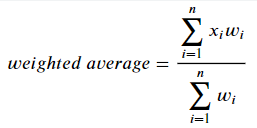

In [71]:
sub_ensemble_trn = y.copy(deep = True)

for i, preds in enumerate(test_preds):
    sub_ensemble[target] = sub_ensemble[target] + (test_preds[i].argmax(axis=1) * OOF_val_score[i]) #multiply preds by their corresponding auc score
    sub_ensemble_trn= sub_ensemble_trn + (train_preds[i].argmax(axis=1) * OOF_val_score[i])
    
sub_ensemble_trn =   (sub_ensemble_trn/ sum(OOF_val_score) ).values
sub_ensemble_trn = np.round(sub_ensemble_trn).astype('int32')
sub_ensemble_trn= sub_ensemble_trn+3

sub_ensemble[target] =   (sub_ensemble[target]/ sum(OOF_val_score)).values 
sub_ensemble[target] = np.round(sub_ensemble[target]).astype('int32')
sub_ensemble= sub_ensemble+3
sub_ensemble.to_csv("sub_weighted_ensemble.csv")
sub_ensemble.head()

quality
Id           
2056        5
2057        5
2058        6
2059        6
2060        6

# ✅ Post-Prediction Analysis & Manipulation ✅

#### i. Calibration: 
    * Our models may not be optimized and a simple linear model trained on our training predictions may be able to smooth out any inconsistencies with our model through fitting and additional linear model on our predictions 
#### ii. Prediction shifting

In [72]:
# Create an Ensemble of the training data predictions 
sub_train = pd.DataFrame(index = y.index)
sub_train[target] = 0

for i, preds in enumerate(train_preds):
    sub_train[target] = sub_train[target] + (train_preds[i].argmax(axis=1) * OOF_val_score[i]) #multiple preds by their corresponding auc score
    
sub_train[target] =   sub_train[target]/ sum(OOF_val_score) 
sub_train[target] = np.round(sub_train[target]).astype('int32')
sub_train = sub_train+3
sub_train.to_csv("sub_train.csv")
sub_train.head()

quality
0        6
1        6
2        7
3        5
4        6

### i. Calibration
* We will calibrate our **test predictions** by fitting a linear regression model to a dataframe of our **training predictions** from each models Cross Validation. 
* This fitted calibrated model will then predict the **test predictions** and hopefully smooth out the values and provide a final test prediction 

In [73]:
CALIBRATION = "linear"

In [74]:
if CALIBRATION == "linear":
    model = LogisticRegression(max_iter = 10000)
elif CALIBRATION=='gaus': 
    model = GaussianNB()
elif CALIBRATION=='CV':
    model = CalibratedClassifierCV(lin_model, method='isotonic', cv=5)
    
model.fit(mean_probs_trn, np.ravel(y))
y_cal_trn  = model.predict_proba(mean_probs_trn)
y_cal_test  = model.predict_proba(mean_probs)
y_cal_test = y_cal_test.argmax(axis =1)
y_cal_test= y_cal_test
y_cal_test

array([3, 2, 3, ..., 2, 2, 2])

In [75]:
sub_cal[target] = y_cal_test
print("Calibrated values (inital 5 rows)")
sub_cal.to_csv("sub_cal.csv")
sub_cal = sub_cal+3
sub_cal.head()

Calibrated values (inital 5 rows)


quality
Id           
2056        6
2057        5
2058        6
2059        6
2060        6

## Post-Prediction Analysis 

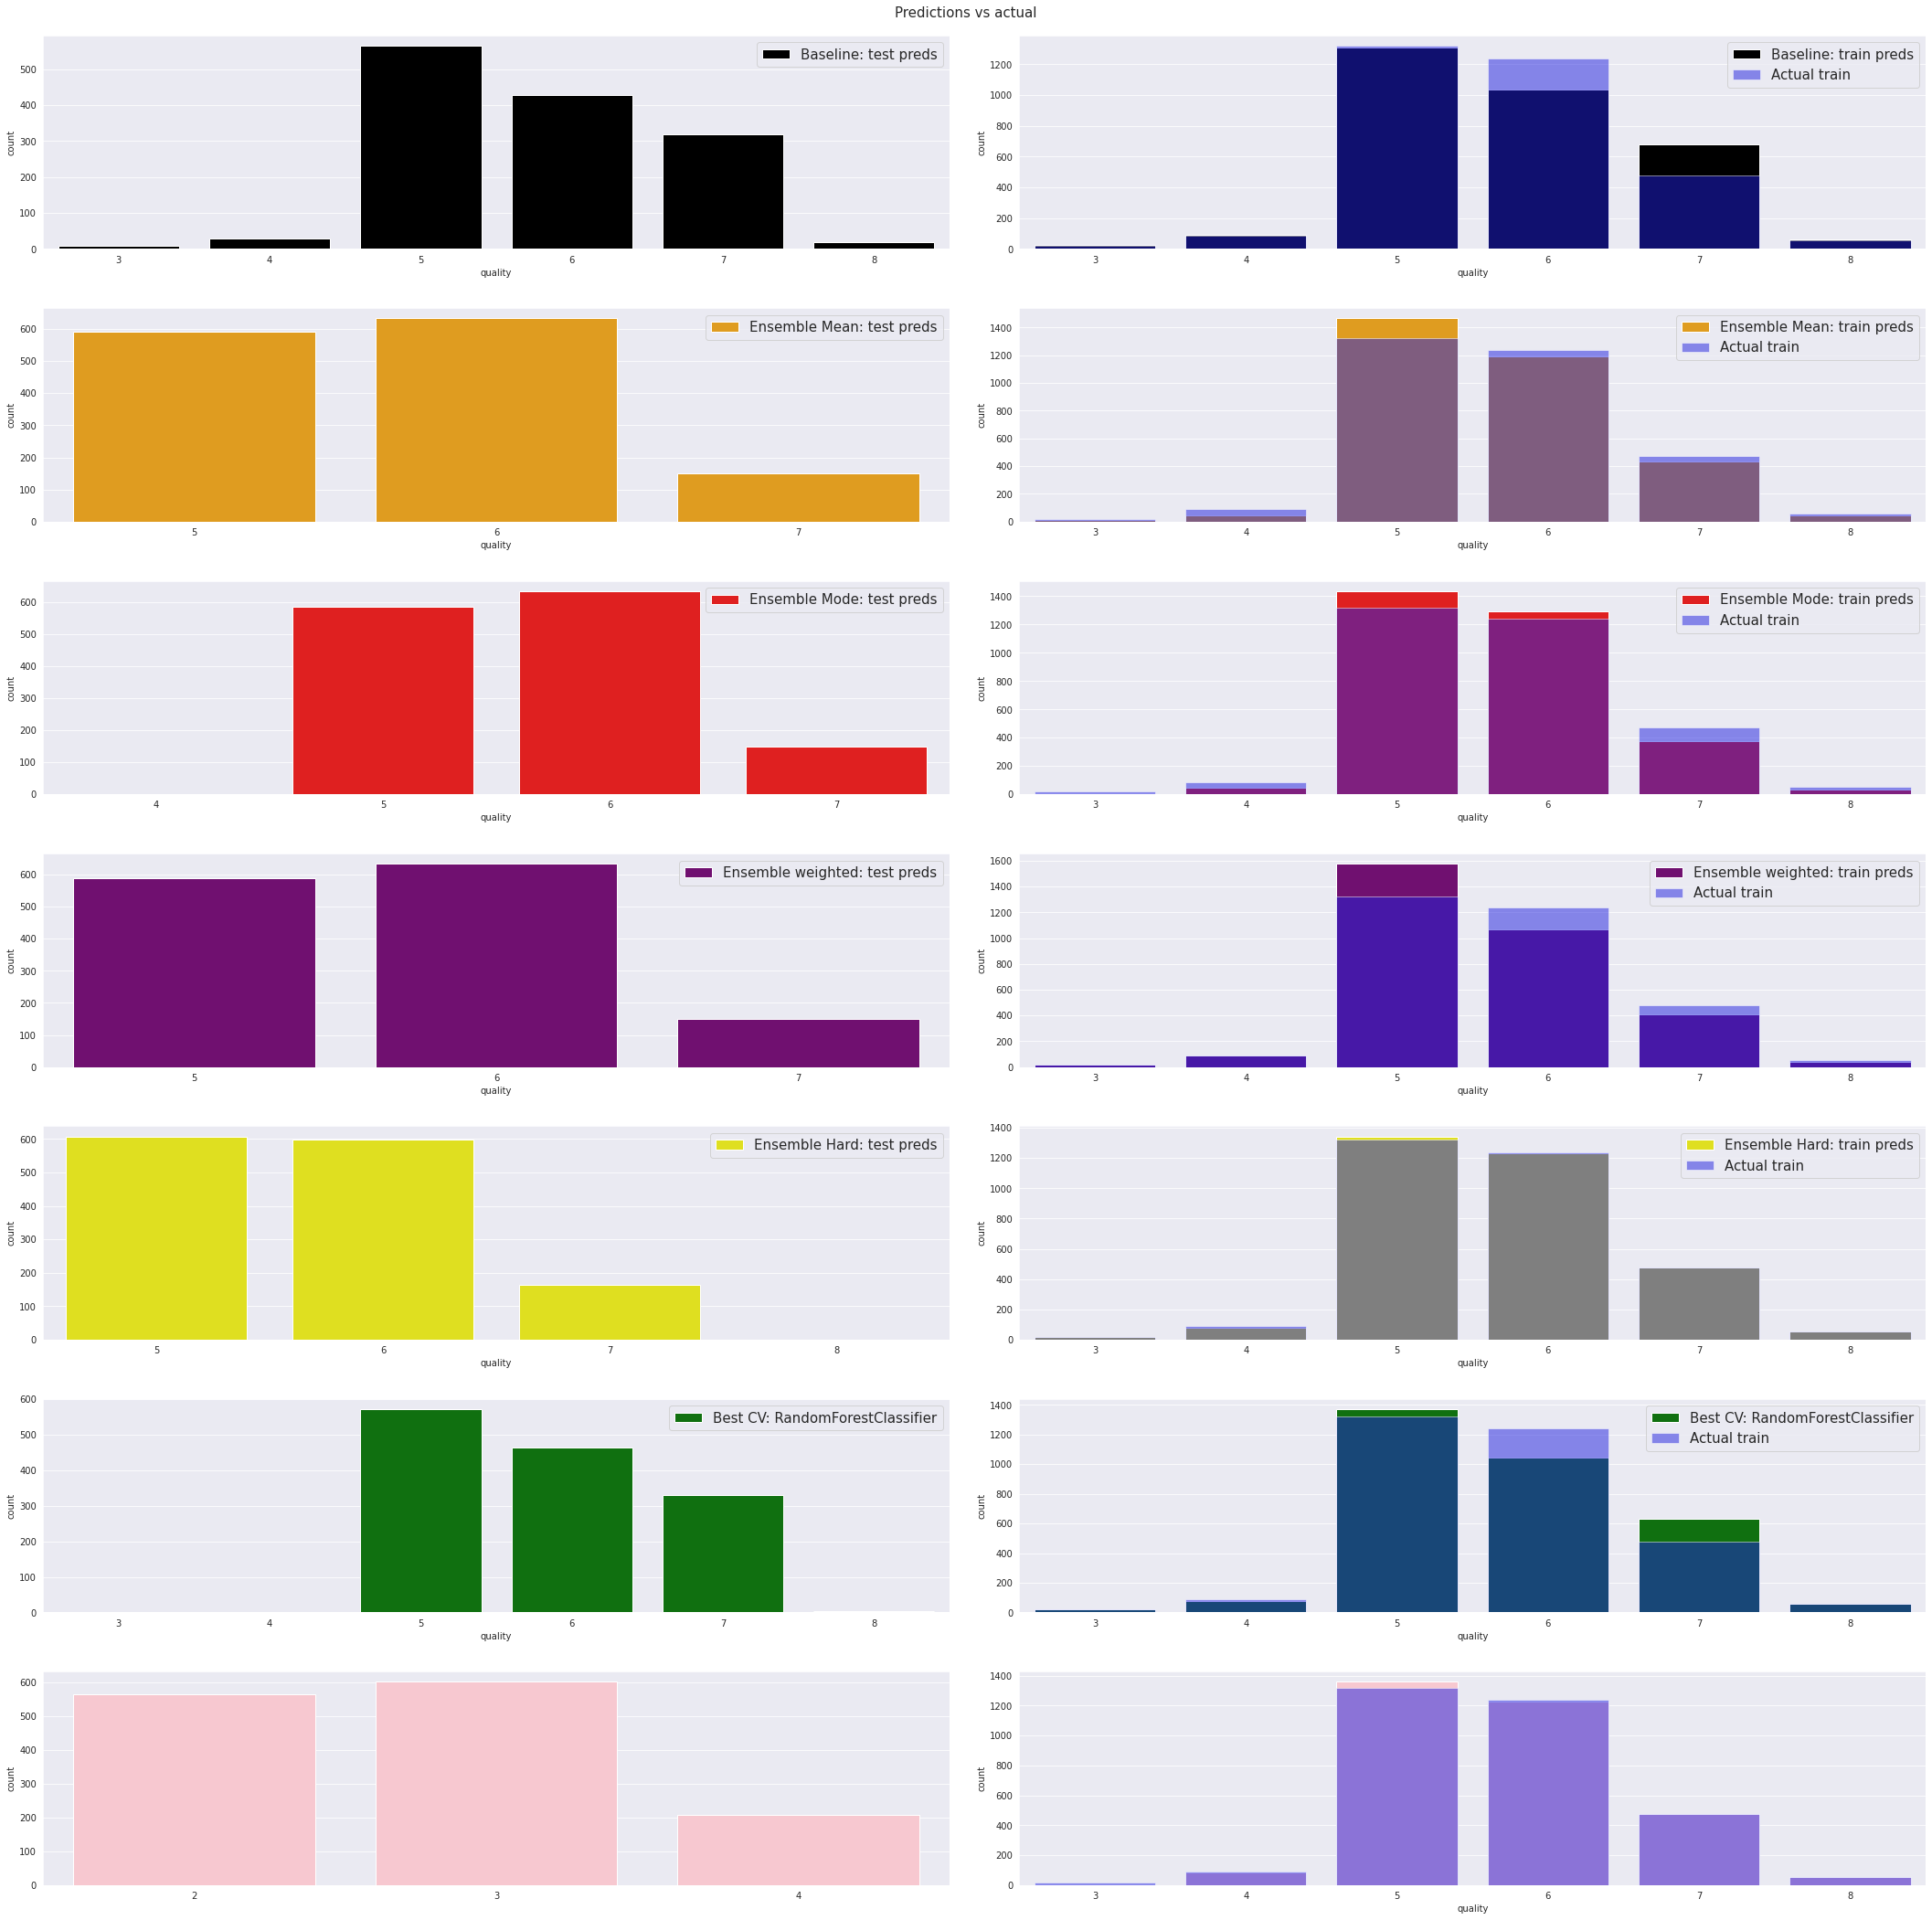

In [76]:
fig, ax = plt.subplots(7,2, figsize = (30,30))
ax = np.ravel(ax)

sns.countplot(x =sub_base[target], label = f"Baseline: test preds", color ='black', ax= ax[0])
sns.countplot(x =trn_preds_base.argmax(axis =1)+3, label = f"Baseline: train preds", color ='black', ax= ax[1])
sns.countplot(x =y+3, label = f"Actual train",alpha =0.5, color ='blue', ax= ax[1])

sns.countplot(x =mean_ensemble[target], label = f"Ensemble Mean: test preds", color ='orange', ax= ax[2])
sns.countplot(x =mean_ensemble_trn, label = f"Ensemble Mean: train preds", color ='orange', ax= ax[3])
sns.countplot(x =y+3, label = f"Actual train",alpha =0.5, color ='blue', ax= ax[3])

sns.countplot(x =mode_ensemble[target], label = f"Ensemble Mode: test preds", color ='red', ax= ax[4])
sns.countplot(x =mode_ensemble_trn, label = f"Ensemble Mode: train preds", color ='red', ax= ax[5])
sns.countplot(x =y+3, label = f"Actual train",alpha =0.5, color ='blue', ax= ax[5])

sns.countplot(x =sub_ensemble[target], label = f"Ensemble weighted: test preds", color ='purple', ax= ax[6])
sns.countplot(x =sub_ensemble_trn, label = f"Ensemble weighted: train preds", color ='purple', ax= ax[7])
sns.countplot(x =y+3, label = f"Actual train",alpha =0.5, color ='blue', ax= ax[7])

sns.countplot(x =hard_ensemble[target], label = f"Ensemble Hard: test preds", color ='yellow', ax= ax[8])
sns.countplot(x =argmax_val_trn, label = f"Ensemble Hard: train preds", color ='yellow', ax= ax[9])
sns.countplot(x =y+3, label = f"Actual train",alpha =0.5, color ='blue', ax= ax[9])

sns.countplot(x =sub_best_cv[target], label = f"Best CV: {list(models)[np.argmax(OOF_val_score)]}", color ='green',ax = ax[10])
sns.countplot(x =sub_best_cv_trn, label = f"Best CV: {list(models)[np.argmax(OOF_val_score)]}", color ='green', ax= ax[11])
sns.countplot(x =y+3, label = f"Actual train",alpha =0.5, color ='blue', ax= ax[11])

sns.countplot(x =y_cal_test, label = f"Calibrated test preds", color ='pink',ax = ax[12])
sns.countplot(x =y_cal_trn.argmax(axis =1), label = f"Calibrated train preds", color ='pink', ax= ax[13])
sns.countplot(x =y+3, label = "Actual train",alpha =0.5, color ='blue', ax= ax[13])

for i in range(12):
    ax[i].legend(fontsize = 15)
    
plt.suptitle("Predictions vs actual", fontsize = 15)
plt.tight_layout(pad = 3)
plt.show()

<span style="color:blue;font-size:1.5em;">Notes: Prediction Analysis</span>
* Im not happy with the test predictions for most of the models. We can see that only 3 classes are predicted for most of them
* This is generally the case for highly imbalanced datasets 
* Solutions are the same as stated previously: 
 * Oversampling (not implemented)
 * Additional features (not implemented)
 * Class weighting of models (implemented)
 
##### Note: Random Forest and Hard Voting Ensembling seem to be the best predictions here. We should use these for submission 

### Residual  Analysis 
* Lets look at our Validation predictions and see where our best cross-validation model incorrectly predicted the classification 

In [77]:
y_ =pd.DataFrame(y+3)
y_.loc[val_index,"val_predictions"] = np.argmax(val_preds[np.argmax(OOF_val_score)], axis =1) +3
y_["val_predictions"] = y_["val_predictions"].astype(int)

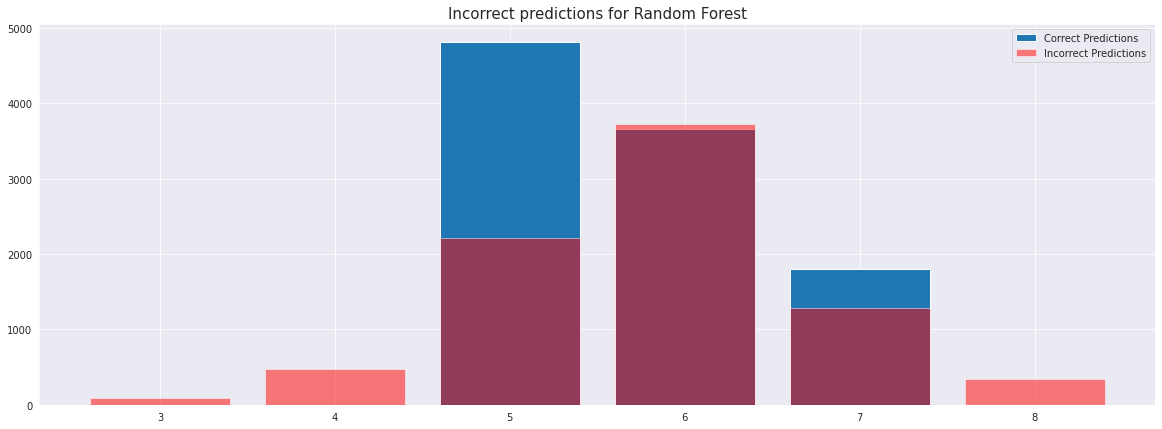

In [78]:
plt.figure(figsize = (20,7))
true_vals = y_.loc[y_.quality ==y_.val_predictions].groupby("quality").sum()
inco_vals = y_.loc[y_.quality !=y_.val_predictions].groupby("quality").sum()
plt.bar(x = list(true_vals.index), height = true_vals.val_predictions, label = "Correct Predictions")
plt.bar(x = list(inco_vals.index), height = inco_vals.val_predictions, alpha = 0.5, color = "r", label = "Incorrect Predictions")
plt.title("Incorrect predictions for Random Forest" ,fontsize =15)
plt.legend()
plt.show()

<span style="color:blue;font-size:1.2em;">Notes:</span>
* **Zero values of Class 3/ 4/8  were correctly predicted**: this is very poor and we would was to try improve this my helping our model identify class 3, 4 and 5 better (TIP: Looking at our shap graphs might give us a feature that we could engineer to assist)
* **Equal amounts of Correct/ Incorrect predictions for class 6**: Same as above, however this class has a large number of values. As such we should focus on this to improve our score the most

Lets try look at the incorrect predictions and count the classes that were predicted instead 

In [79]:
#Create a cross tab of all classes and the number of incorrect predictions by class
df_= pd.crosstab(y_.quality, y_.val_predictions)
# fill correct predictions as 0 
for row_col in list(df_.index):
    try:
        df_.loc[row_col,df_.columns==row_col] = 0
    except:
        pass
print("True values vs number of incorrect predictions\n")
df_

True values vs number of incorrect predictions



val_predictions  4    5    6    7  8
quality                             
3                0   13    5    0  0
4                0   62   23    3  0
5                4    0  297   58  1
6                2  340    0  282  5
7                0   42  169    0  7
8                0    3   18   32  0

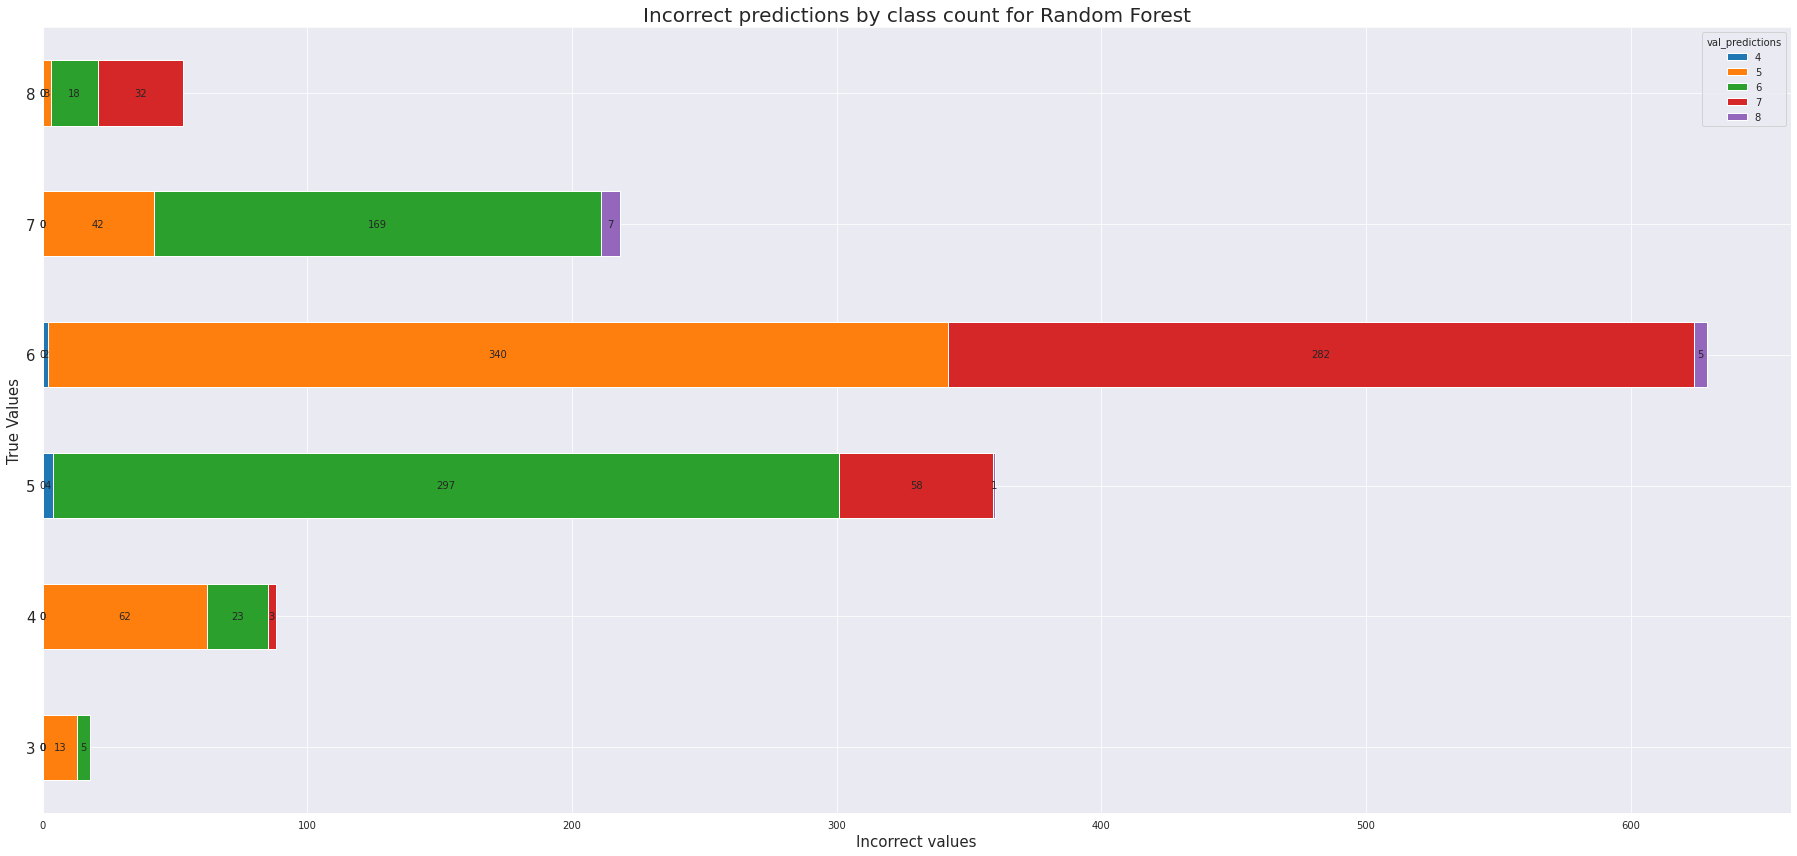

In [80]:
ax = df_.plot(kind="barh", figsize =(25,12), stacked=True,)
for c in ax.containers:
    ax.bar_label(c, label_type='center')
plt.yticks(fontsize =15)
plt.xlabel("Incorrect values",fontsize =15)
plt.title("Incorrect predictions by class count for Random Forest" ,fontsize =20)
plt.tight_layout()
plt.ylabel("True Values",fontsize =15)
plt.show()

<span style="color:blue;font-size:1.2em;">Notes:</span>
* Again we can see that class 6 is highly incorrectly predicted
* **Class 6** has **+-350** predictions that are **incorrectly predicted as class 5**

<span style="color:red;font-size:1.0em;">Potential Solutions: Incorrect predictions </span>
1. Additonal features (not implemented)
2. Threshold changes and prediction shifting (see below)

## ii. Prediction shifting (Also called Threshold cuttoff for binary classification)
We now undergo a process of shifting our probabilities such that predictions of 5 are more likely to be 6:
1. select all test predictions that were predicted as 5 and get these indexes 
2. Filter our test predictions by this index 
3. Multiply the probability for class 6 by our percentage (see above)
4. We should now have a data set where we are more likely to predict 6 if the value was orginally 5

**Note**: This process can be highly inconclusive and inaccurate. There is a lot of trial and error here and it may not work as expected

In [81]:
# 350 + 286 values of prediction==6 are incorrect. Lets see what % this is to the total predictions of 5
perc_ =  ((350+286)/ (y+3==5).sum())
# lets get the total change if we increased the value 
perc_ = perc_ + 1
perc_

1.481089258698941

The idea here is to multiply this value to our class 6 probabilities (that were predicted as 5 or 7). Ideally this will increase the number of clas 6 predictions and reduce incorrect class 5 and 7 preds

In [82]:
# get indexes of class 6 
Index_57 = sub_best_cv.reset_index(drop = True)
Index_57 = Index_57[(Index_57.quality==6)|(Index_57.quality==7)].index

df_rf_changed = pd.DataFrame(test_preds[np.argmax(OOF_val_score)])
df_rf_changed.iloc[Index_57,3 ] = df_rf_changed.iloc[Index_57,3 ]* perc_ # multiple class 6 by the percentage 
df_rf_changed = df_rf_changed.idxmax(axis =1)
df_rf_changed = df_rf_changed+3

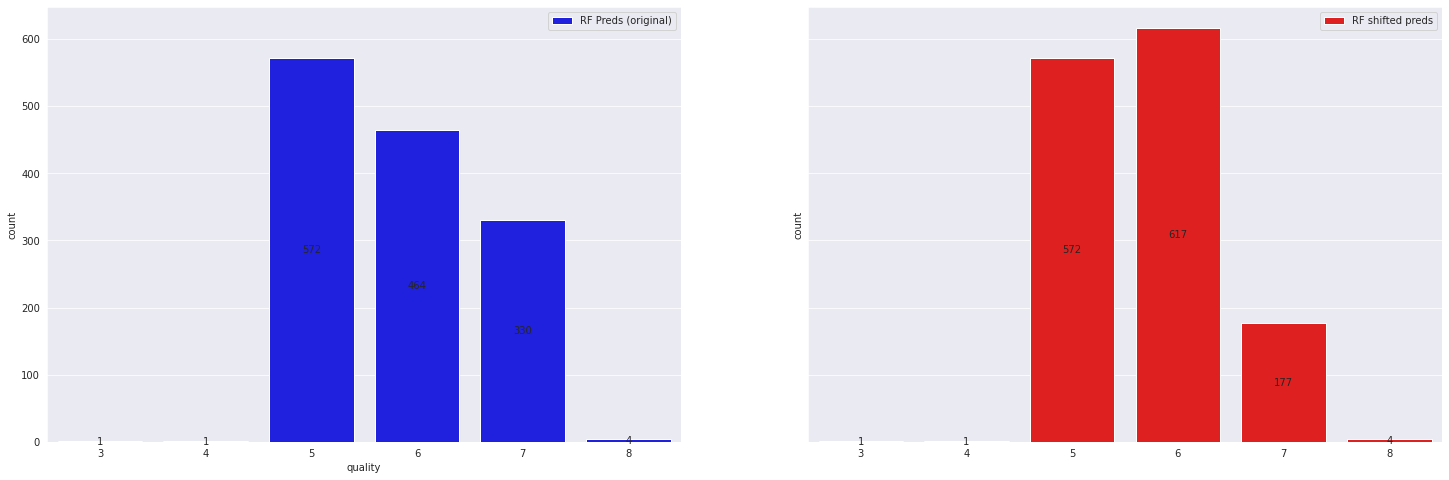

In [83]:
fig, ax = plt.subplots(1,2, figsize = (25,8), sharey = True)
ax_1 = sns.countplot(x =sub_best_cv[target], label = f"RF Preds (original)", color ='blue',ax = ax[0])
ax_2 = sns.countplot(x =df_rf_changed, label = f"RF shifted preds", color ='red', ax= ax[1])

for ax in [ax_1, ax_2]:
    for c in ax.containers:
        ax.bar_label(c, label_type='center')
ax_1.legend()
ax_2.legend()
plt.show()

Class 6 has increased, class 5 and class 7 have decreased

In [84]:
rf_shifted = sub.copy(deep= True)
rf_shifted[target] = df_rf_changed.values
rf_shifted.to_csv("rf_shifted.csv")
rf_shifted

quality
Id           
2056        5
2057        6
2058        5
2059        6
2060        6
...       ...
3423        5
3424        6
3425        5
3426        5
3427        5

[1372 rows x 1 columns]

# Final Notes 
A question I get a lot is how do I improve my score. To put it simply; its a focus on 3 areas: 
1. <span style="color:red;font-size:1em;">Model hyperparameter optimization </span>
1. <span style="color:red;font-size:1em;">Feature Engineering </span>
1. <span style="color:red;font-size:1em;">Post processing your prediction </span>

As noted above, feature engineering & hyperparameter optimization is a lengthy process of trial and error (creating/ dropping and testing new features/parameters) as well as model optimization \
To keep this notebook short I will leave a few things to you

#### Additional Things to Try on Your Own

* PCA columns 
* Feature engineering
* Model Optimization (Hyperparameter Tuning)
* Different Ensembling methods